### Organize Data into CSVs

In [16]:
# imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
### Census Sales Data

df_nonadjust = pd.DataFrame()
df_label = pd.DataFrame()
xlfname = 'mrtssales92-present (1).xlsx'
xl = pd.ExcelFile(xlfname)

### Labels
df_label = xl.parse(xl.sheet_names[0], header=4, usecols='A:B',nrows = 66)
df_label = df_label.drop([0,1,2,3,4,5,6,7])
df_label = df_label.set_axis(["NAICS Code","Business Type"],axis=1)

### Not adjusted
for sheet in reversed(xl.sheet_names):
    df_tmp = pd.DataFrame()
    if sheet == '2023':
        df_tmp = xl.parse(sheet, header=4, usecols='C:K',nrows = 66)
    else:
        df_tmp = xl.parse(sheet, header=4,usecols='C:N',nrows = 66)
    df_tmp = df_tmp.drop([0,1,2,3,4,5,6,7])
    df_nonadjust = pd.concat([df_nonadjust,df_tmp], axis = 1, ignore_index=False,sort=False)

# get quartly sums for each business type

quarters = []
for i in range(len(df_nonadjust)):
    row = []
    temp_sum = 0
    m = 1
    for j in range(len(df_nonadjust.columns)):
        if df_nonadjust.iat[i,j] != '(S)' and df_nonadjust.iat[i,j] != '(NA)' :
            temp_sum+=int(df_nonadjust.iat[i,j])
        if (m % 3 == 0) or (j == len(df_nonadjust.columns)-1):
            row.append(temp_sum)
            temp_sum = 0
            m = 1
        else:
            m+=1
    quarters.append(row)

for i in range(len(quarters)):
    decomposition = seasonal_decompose(quarters[i], model='additive', period=12)
    deseason_temp = quarters[i] - decomposition.seasonal
    quarters[i] = deseason_temp 

df_quarter = df_label
year = 1992
quarters = np.array(quarters)
for i in range(len(quarters[0])):
    q = (i+1) % 4
    label = ''
    if q == 0:
        label = 'Q'+str(4)+' '+str(year)
        year+=1
    else:
        label = 'Q'+str(q)+' '+str(year)
    df_quarter[label]=quarters[:,i]

Census_data = df_quarter.copy() 


csvfile = 'CensusAdjusted.csv'
df_quarter.to_csv(csvfile, index=False)



/var/folders/98/s74dqh4j6sl40rm5n7z1y4zr0000gn/T/ipykernel_74901/2055040586.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_quarter[label]=quarters[:,i]
/var/folders/98/s74dqh4j6sl40rm5n7z1y4zr0000gn/T/ipykernel_74901/2055040586.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_quarter[label]=quarters[:,i]
/var/folders/98/s74dqh4j6sl40rm5n7z1y4zr0000gn/T/ipykernel_74901/2055040586.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

In [23]:
### GDP 

df = pd.read_csv('GDP raw.csv',parse_dates=['DATE'])

quarters = []
for d in df.DATE:
    q = (int(d.month)-1)/3+1
    label = "Q"+str(int(q))+" "+ str(d.year)
    quarters.append(label)

df['Quarter'] = quarters

csvfile = 'GDP.csv'
df.to_csv(csvfile, index=False)

GDP_Data = df


In [24]:
### Zillow Housing Price Data

df = pd.read_csv('Zillow_Raw.csv',parse_dates=['DATE'])
data = pd.DataFrame(zip(df.DATE, df.ZHVI),
               columns =['Date','ZHVI'])


quarters = []
labels = []
m = 1
q = 1
temp_sum = 0
for i in range(len(data.Date)):
    temp_sum+=int(data.ZHVI.iat[i])
    if (m % 3 == 0) or (i == len(data.Date)-1):
        quarters.append(temp_sum/3.0)
        labels.append('Q'+str(q)+' '+str(data.Date.iat[i].year))
        temp_sum = 0
        m = 1
        q+=1
    else:
        m+=1

    if q == 5:
        q = 1


new_data = pd.DataFrame()
new_data['Quarter'] = labels
new_data['ZHVI'] = quarters

csvfile = 'Zillow.csv'
new_data.to_csv(csvfile, index=False)

Zillow_Data = new_data



In [25]:
### Coffee Production Data

df = pd.read_csv('Coffee_production.csv', parse_dates=['DATE'])

quarters = []
for d in df.DATE:
    q = (int(d.month)-1)/3+1
    label = "Q"+str(int(q))+" "+ str(d.year)
    quarters.append(label)

df['Quarter'] = quarters
df = df.set_axis(["Date","PI","Quarter"],axis=1)

csvfile = 'Coffee.csv'
df.to_csv(csvfile, index=False) 

Coffee_Data = df

### Normalize Data

In [31]:
# explicit function to normalize array
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)    
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

def quarter_to_num(columns):
    tmp = []
    for i in range(len(columns)):
        q_y = [int(columns[i][1]),int(columns[i][3:])]
        tmp.append(q_y)
    return np.array(tmp)
    

Census_data = df_quarter.copy()
c = len(Census_data.columns)
r = len(Census_data)

census_y = []
census_names = []
census_x = quarter_to_num(Census_data.columns[2:])
# Census
for i in range(r):
    row = Census_data.iloc[i]
    n_row = normalize(row[2:], 0 , 1)
    census_y.append(n_row)
    census_names.append(row[1])
    for j in range(2,c):
        Census_data.at[i,Census_data.columns[j]] = n_row[j-2]
census_y = np.array(census_y)

# GDP
GDP_Data.GDPC1 = normalize(GDP_Data.GDPC1, 0 , 1)
GDP_x = quarter_to_num(GDP_Data.Quarter)
GDP_y = np.array(GDP_Data.GDPC1)

# Zillow
Zillow_Data.ZHVI = normalize(Zillow_Data.ZHVI, 0 , 1)
Zillow_x = quarter_to_num(Zillow_Data.Quarter)
Zillow_y = np.array(Zillow_Data.ZHVI)

# Coffee
Coffee_Data.PI = normalize(Coffee_Data.PI, 0 , 1)
Coffee_x = quarter_to_num(Coffee_Data.Quarter)
Coffee_y = np.array(Coffee_data.PI)



AttributeError: 'list' object has no attribute 'PI'

In [32]:
# get x an y for each to be used in regression

# Census
# census_y consists of rows of all the sales for different categories
# census_names consists of all the names of categories, same indices as their corresponding values 
# census_x contains a list of years and corresponding quarters
census_x_interval = census_x[:,1]+census_x[:,0]/4.0 # this contains years plus quarter/4 to create incremented x values

# GDP
# GDP_y consists of all GDP values
# GDP_x consists of a list of years and corresponding quarters
GDP_x_interval = GDP_x[:,1]+GDP_x[:,0]/4.0

# Zillow
# Zillow_y consists of all house index values
# Zillow_x consists of a list of years and corresponding quarters
Zillow_x_interval = Zillow_x[:,1]+Zillow_x[:,0]/4.0

# Coffee
# Coffee_y consists of all producer indexes 
# Coffee_x consists of a list of years and corresponding quarters
Coffee_x_interval = Coffee_x[:,1]+Coffee_x[:,0]/4.0

### Initial Regression Models

### Polynomial Regression

Motor vehicle and parts dealers
Coefficients are:
[-4.57061395e+01  2.29682913e-02]
MSE =  0.0004087094119347704


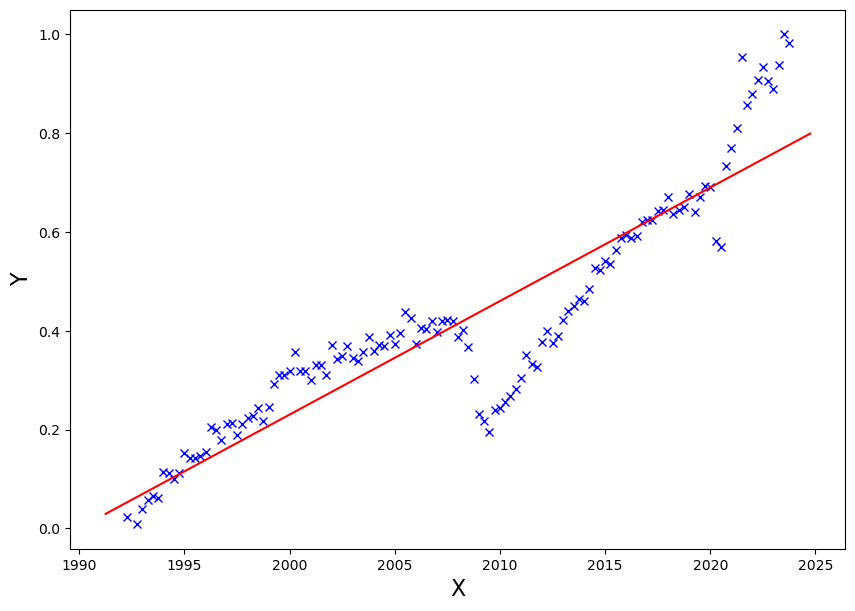

Automobile and other motor vehicle dealers
Coefficients are:
[-4.56024435e+01  2.29182064e-02]
MSE =  0.0004633215106003676


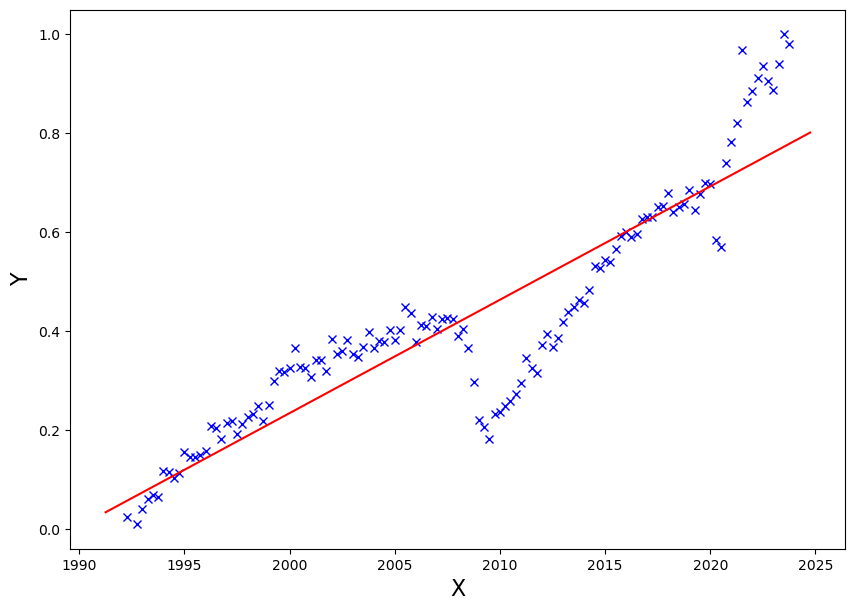

Automobile dealers
Coefficients are:
[-4.58606400e+01  2.30444421e-02]
MSE =  0.00046288051753181237


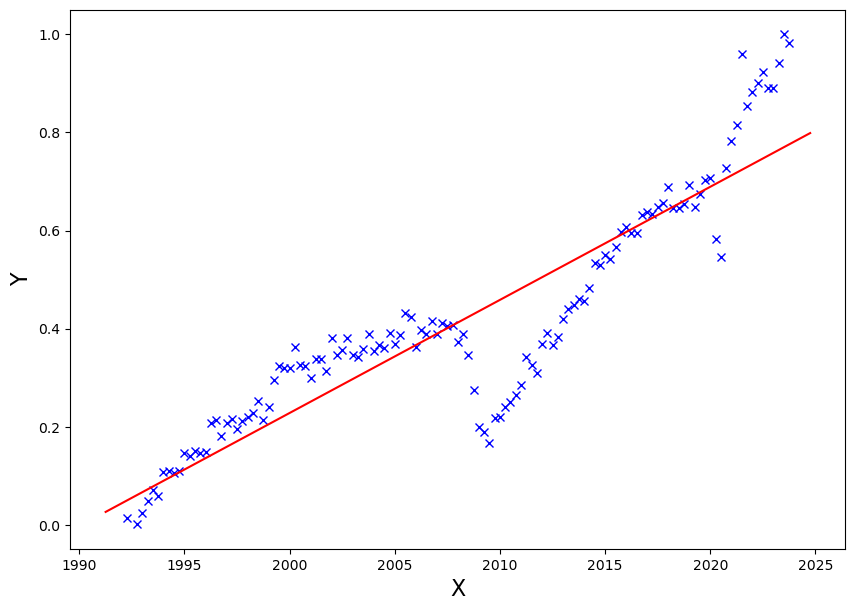

New car dealers
Coefficients are:
[-4.52816894e+01  2.27613491e-02]
MSE =  0.0005143336903488335


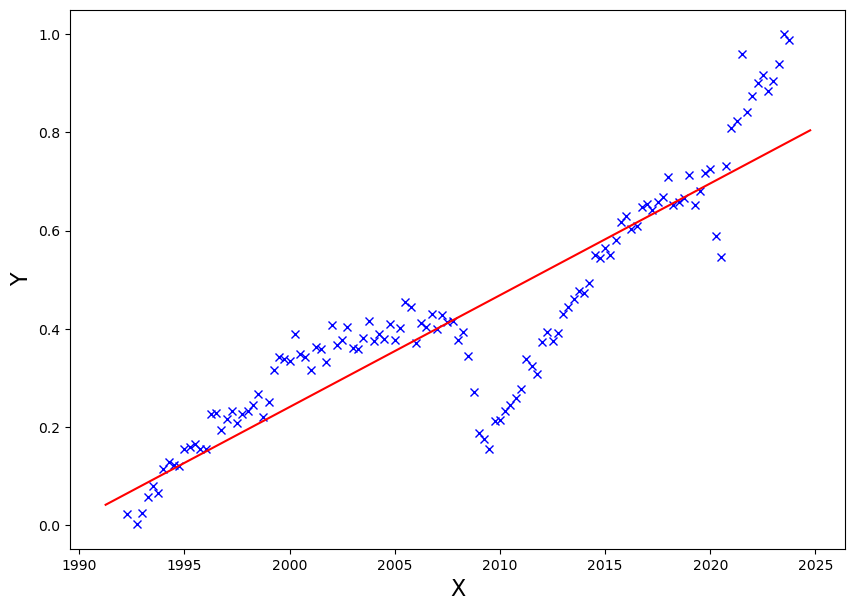

Used car dealers
Coefficients are:
[-4.75885909e+01  2.38852629e-02]
MSE =  0.0003134723906844872


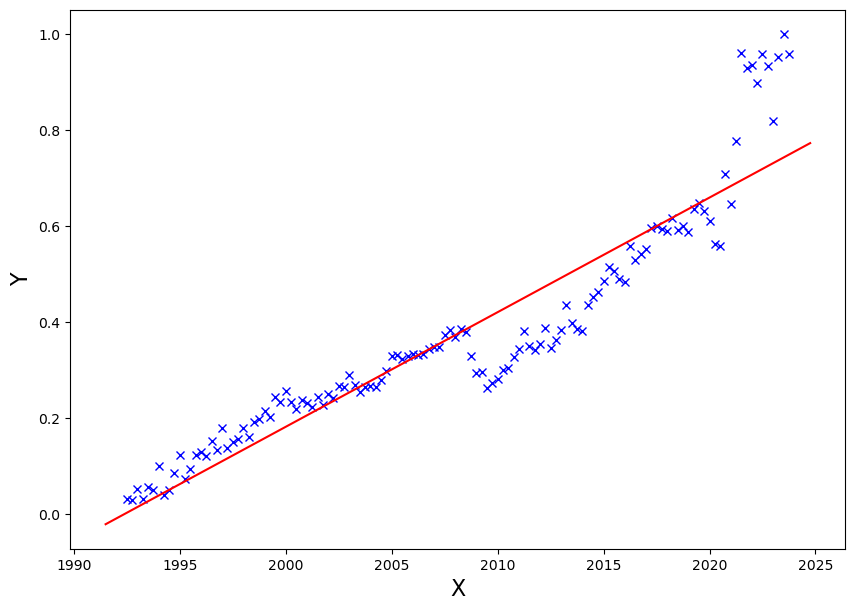

Automotive parts, acc., and tire stores
Coefficients are:
[-4.66512530e+01  2.34186951e-02]
MSE =  5.776796904968119e-05


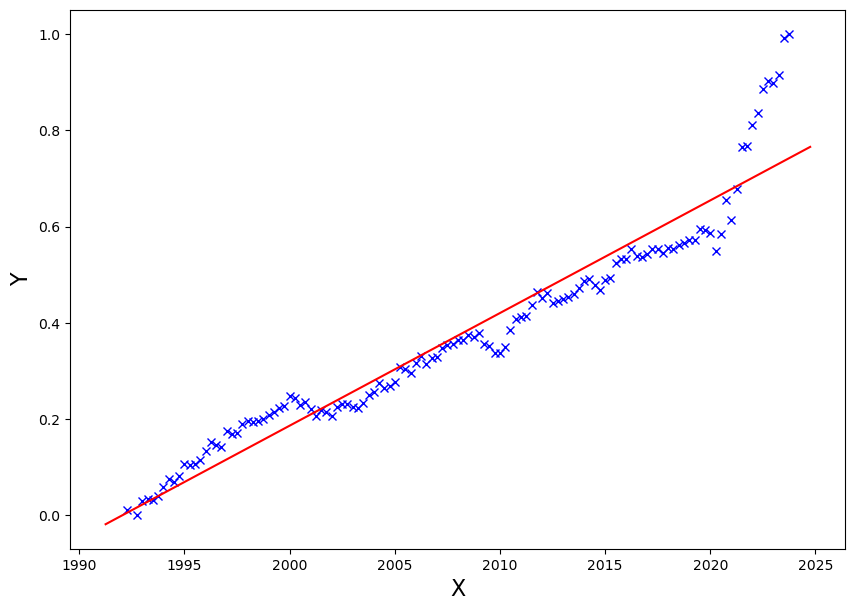

Furniture, home furn, electronics, and appliance stores
Coefficients are:
[-3.68874298e+01  1.86855930e-02]
MSE =  0.0005676960574755772


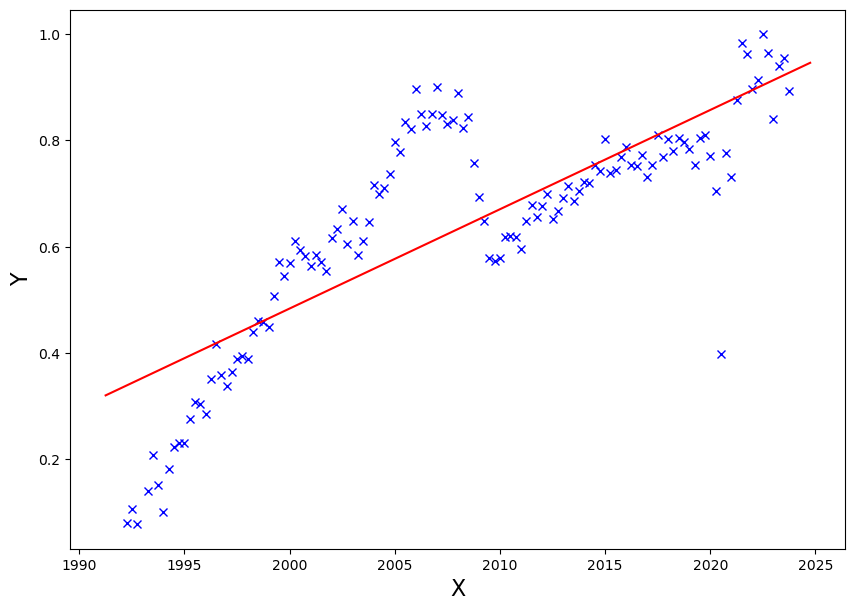

Furniture and home furnishings stores
Coefficients are:
[-4.39156499e+01  2.21146794e-02]
MSE =  0.0005613685926176876


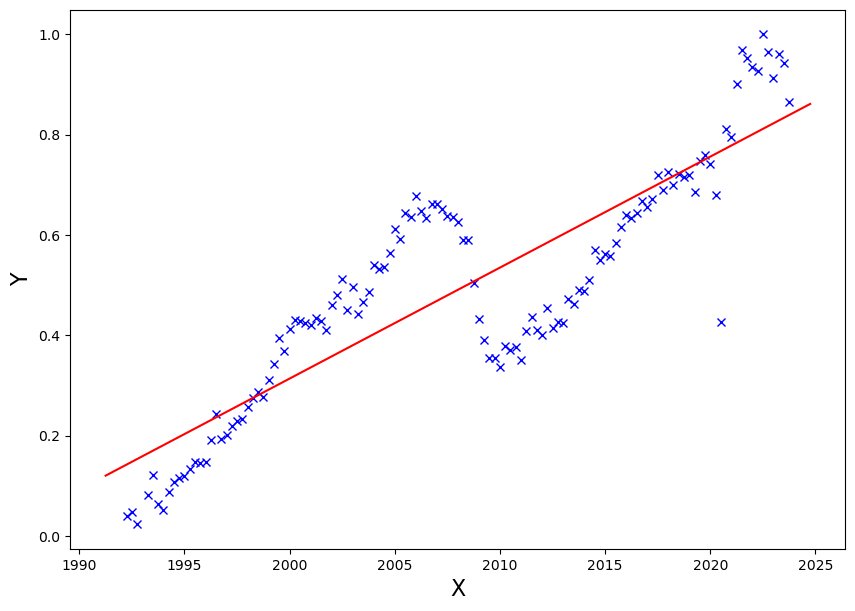

Furniture stores
Coefficients are:
[-4.18841637e+01  2.10730566e-02]
MSE =  0.0005851886210364153


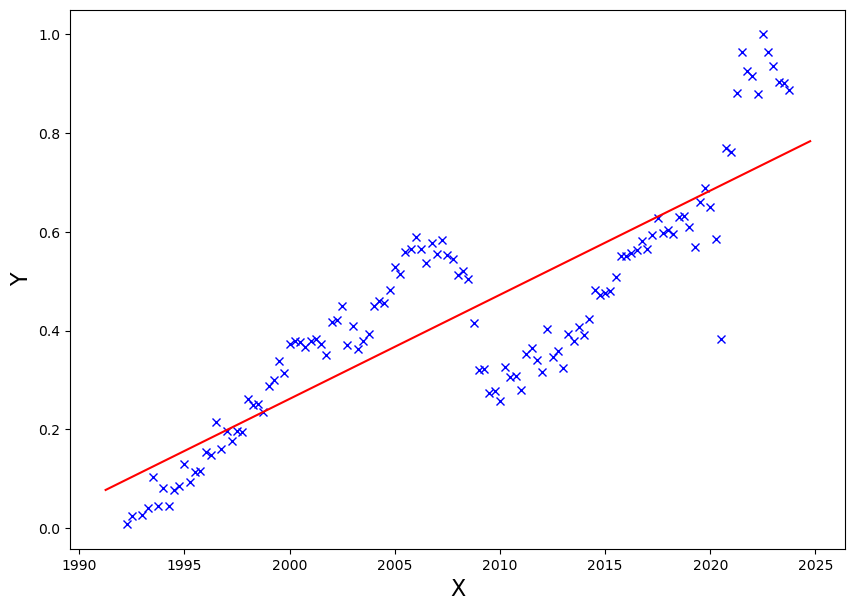

Home furnishings stores
Coefficients are:
[-3.05332395e+00  1.85839614e-03]
MSE =  0.0015698707462428346


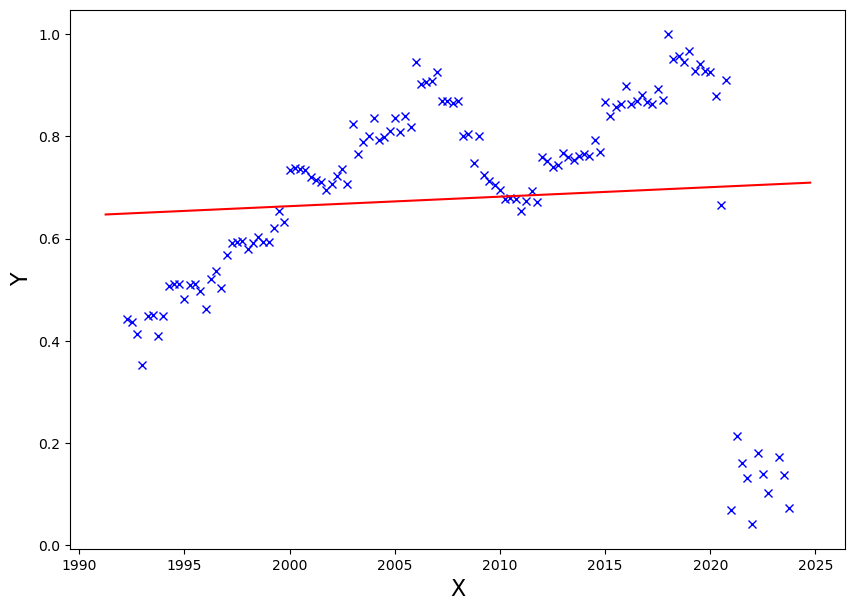

Floor covering stores
Coefficients are:
[-1.14513059e+04  1.14233900e+01 -2.84867086e-03]
MSE =  0.0007306586263020818


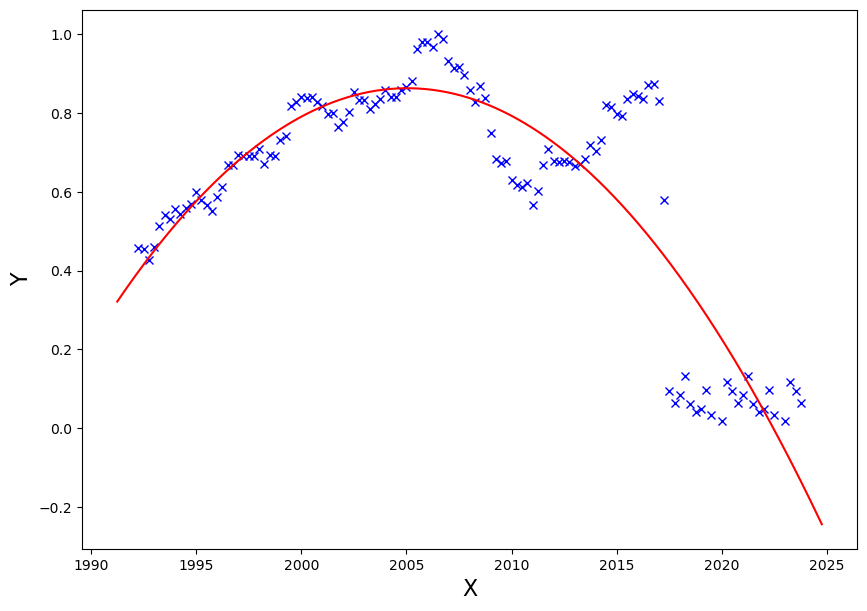

All other home furnishings stores
Coefficients are:
[-1.11581384e+04  1.10985326e+01 -2.75961169e-03]
MSE =  0.0014759983084965448


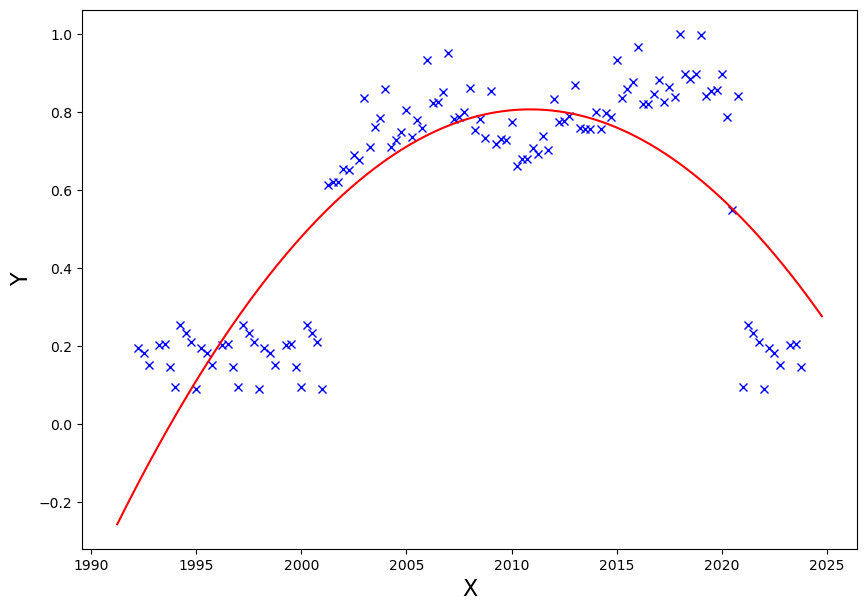

Electronics and appliance stores
Coefficients are:
[-1.87240746e+01  9.65101021e-03]
MSE =  0.0008861942230917196


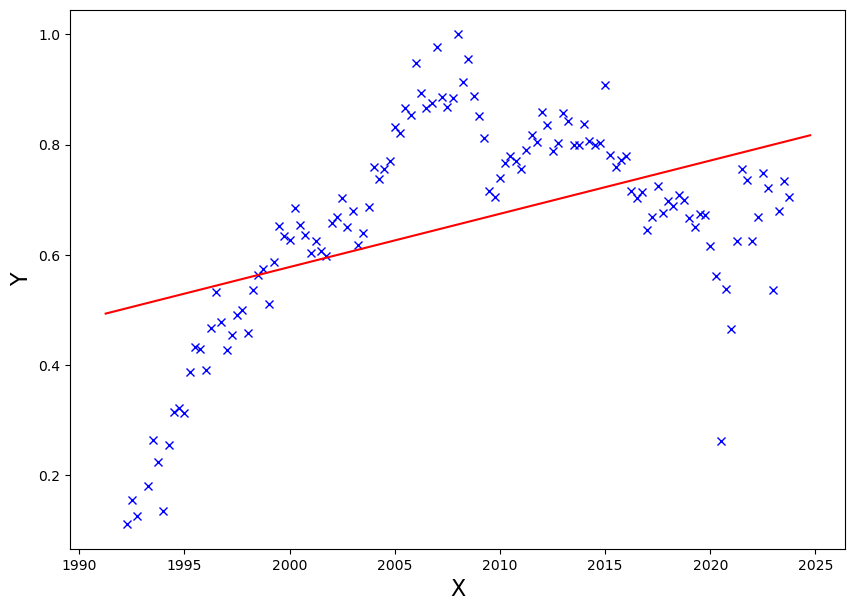

Household appliance stores
Coefficients are:
[-4.84105098e+01  2.43587362e-02]
MSE =  0.00037383989269377616


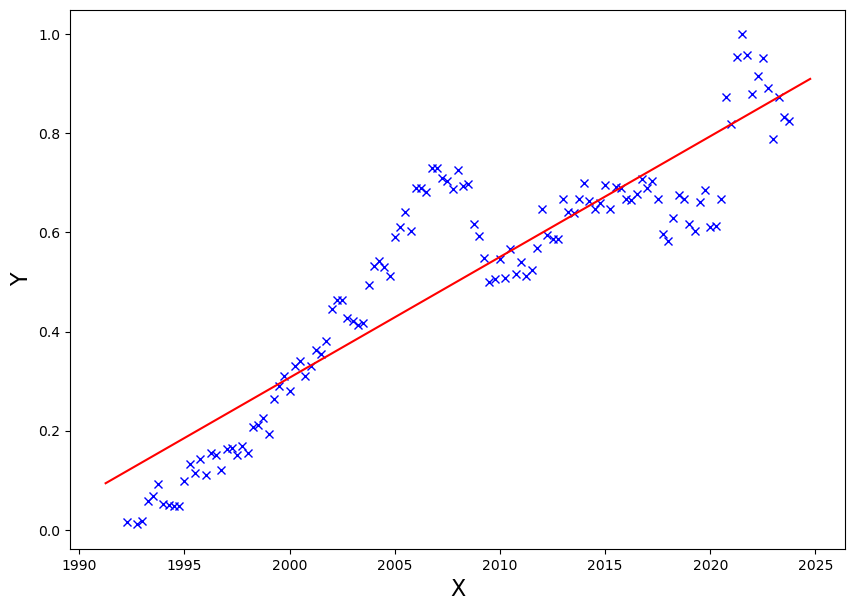

Electronics stores
Coefficients are:
[-2.66391737e+01  1.36247032e-02]
MSE =  0.0016406471964441165


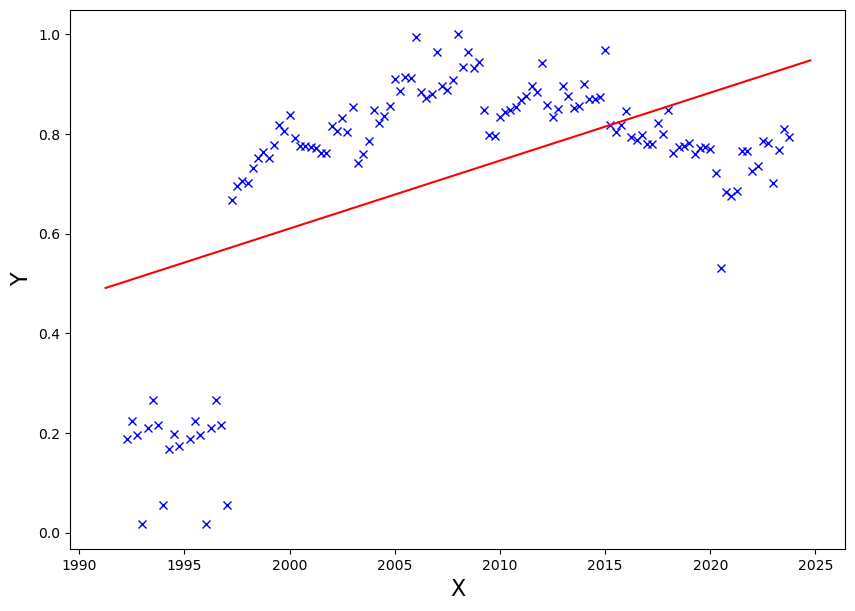

Building mat. and garden equip. and supplies dealers
Coefficients are:
[-4.39150274e+01  2.20831894e-02]
MSE =  0.0003641453291338346


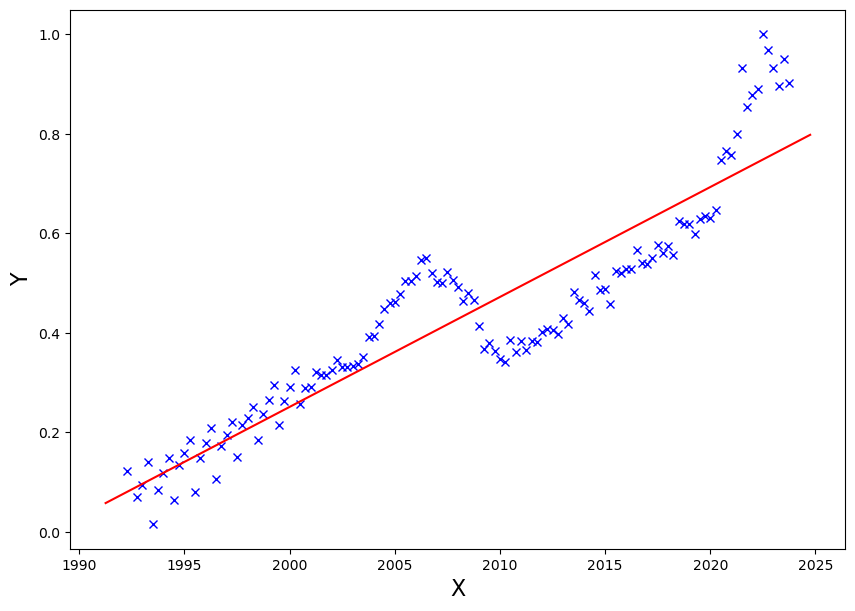

Building mat. and supplies dealers
Coefficients are:
[-4.40598149e+01  2.21527008e-02]
MSE =  0.00038989188514540463


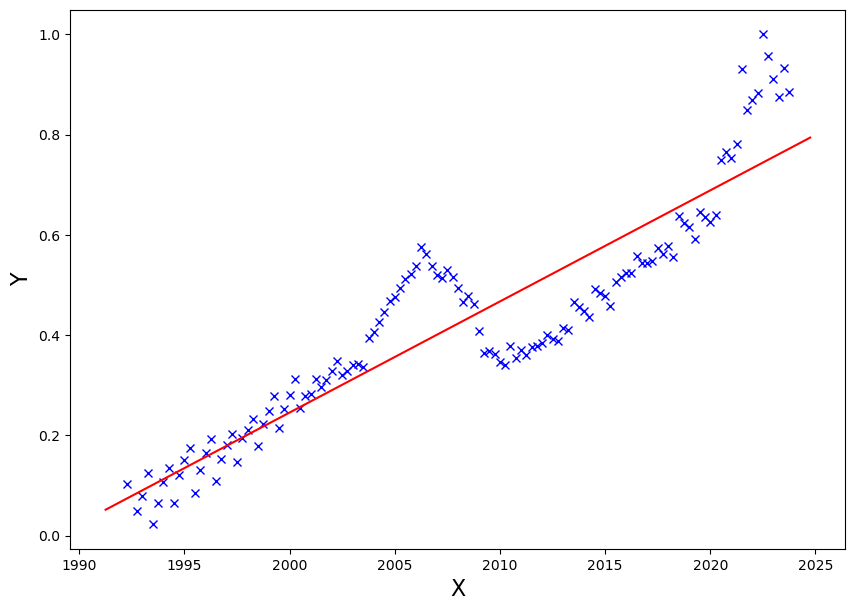

Paint and wallpaper stores
Coefficients are:
[-5.23579809e+01  2.63004526e-02]
MSE =  0.0006302931032074907


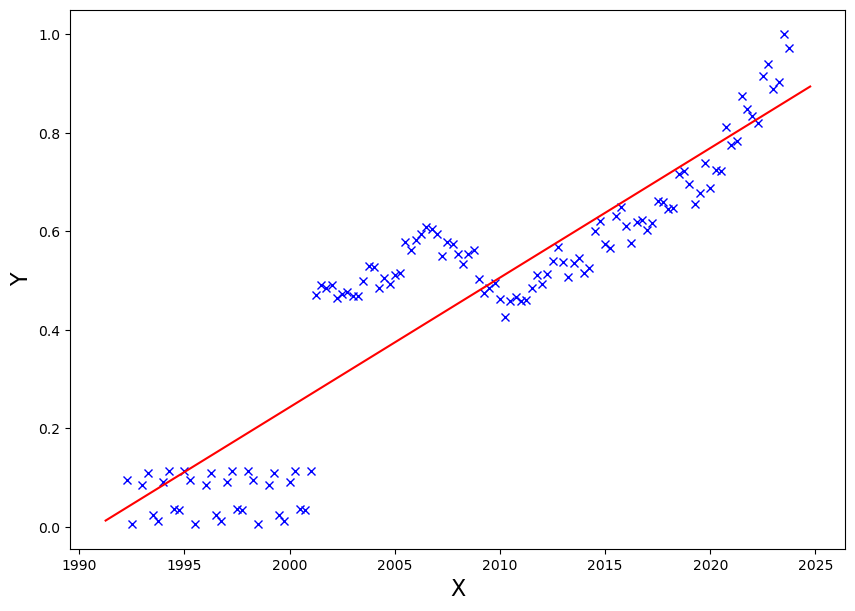

Hardware stores
Coefficients are:
[-4.86345151e+01  2.43823410e-02]
MSE =  0.00035232940592324225


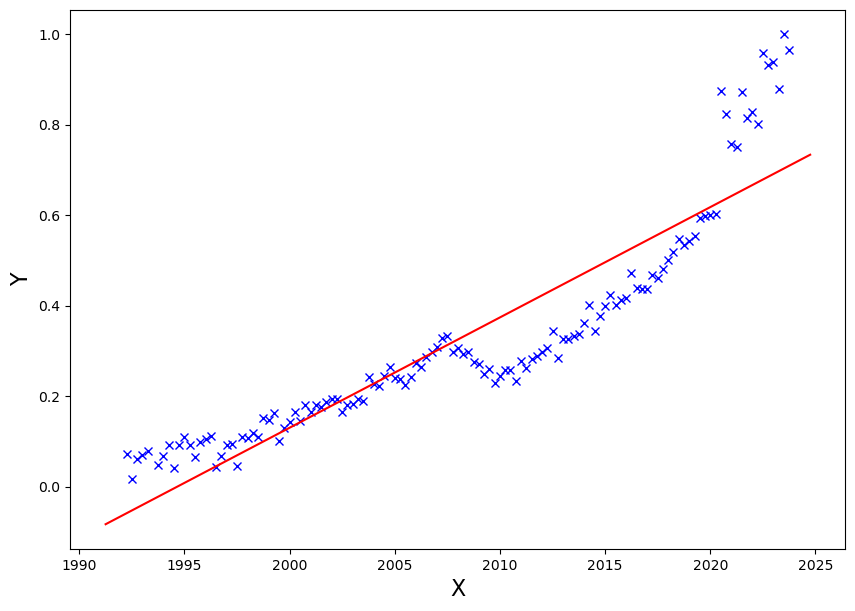

Food and beverage stores
Coefficients are:
[-5.71358651e+01  2.86203636e-02]
MSE =  0.00014493820929586983


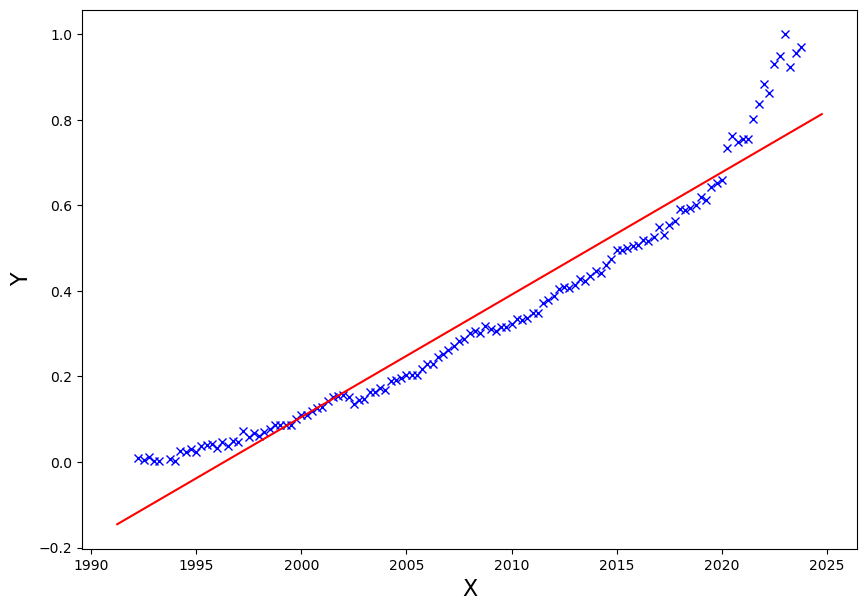

Grocery stores
Coefficients are:
[-5.65294933e+01  2.83183985e-02]
MSE =  0.0001430091450783305


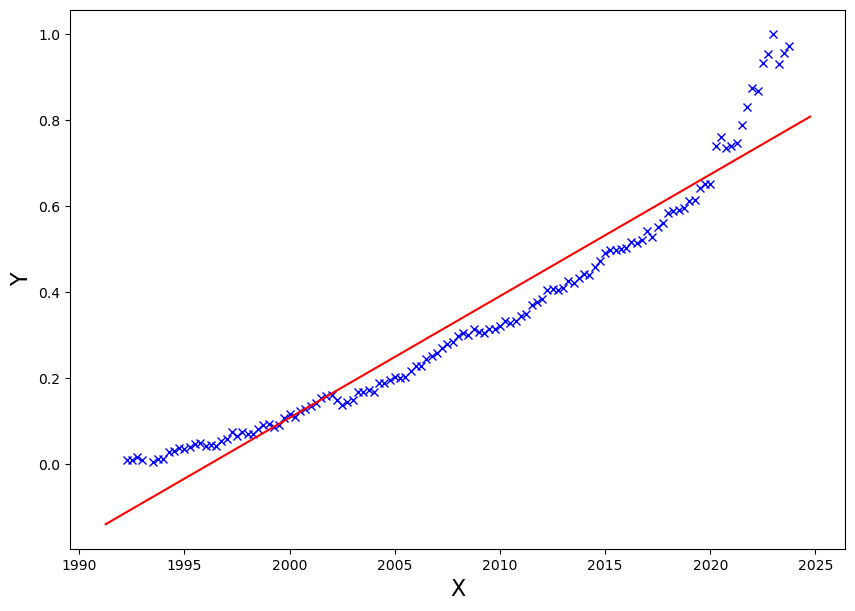

Supermarkets and other grocery (except convenience) stores
Coefficients are:
[-6.40874479e+01  3.21550464e-02]
MSE =  0.00046678376806395116


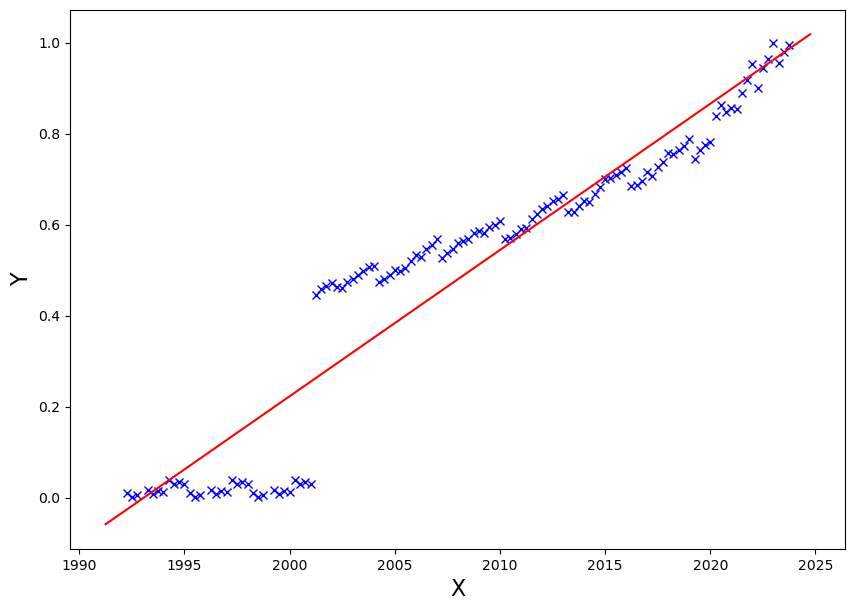

Beer, wine, and liquor stores
Coefficients are:
[-5.73891397e+01  2.87675115e-02]
MSE =  0.00020281816807484504


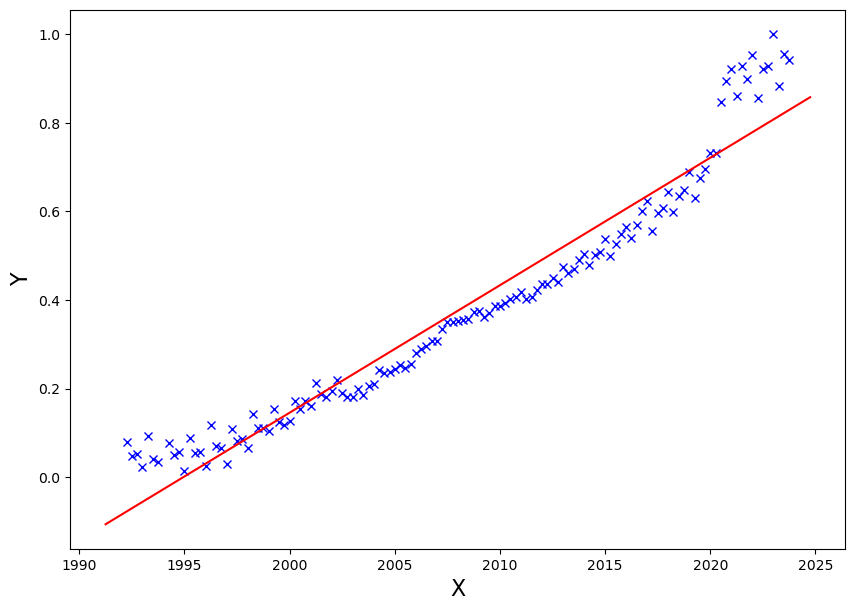

Health and personal care stores
Coefficients are:
[-6.02383249e+01  3.02076349e-02]
MSE =  1.740292383056337e-05


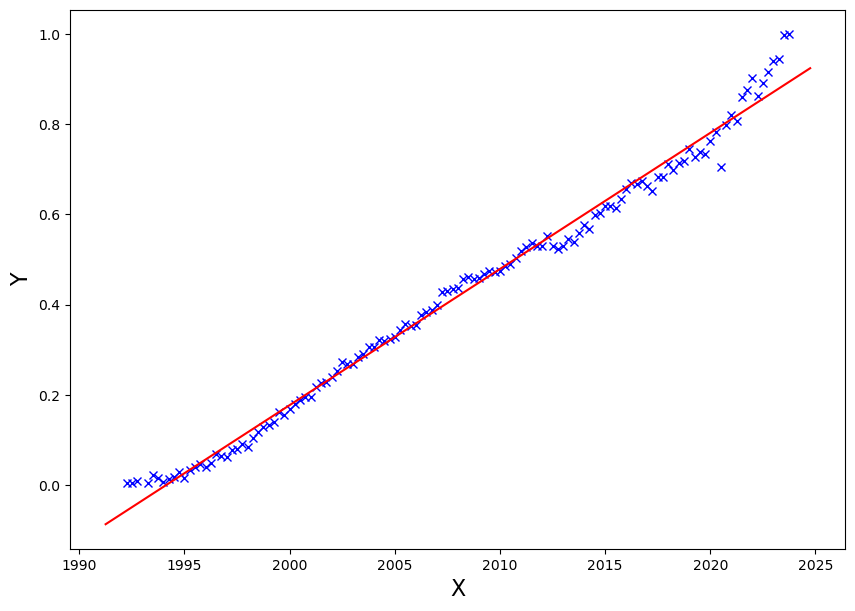

Pharmacies and drug stores
Coefficients are:
[-6.02969161e+01  3.02375371e-02]
MSE =  2.274567322945563e-05


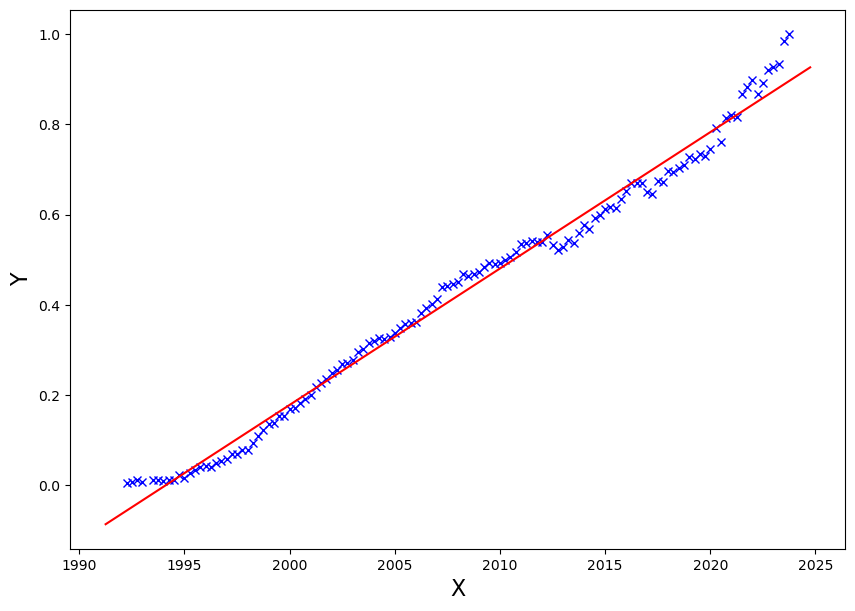

Gasoline stations
Coefficients are:
[-4.73296471e+01  2.37529473e-02]
MSE =  0.0002369189654956437


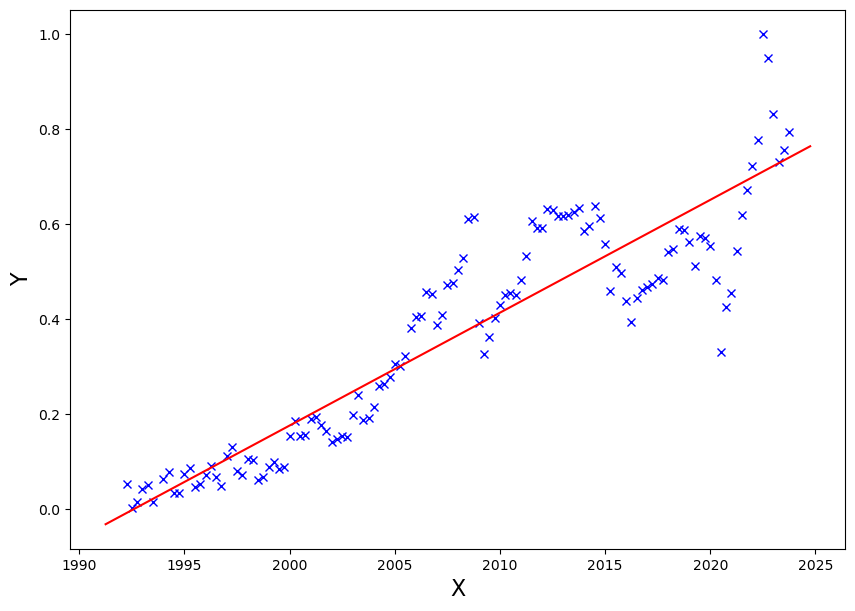

Clothing and clothing access. stores
Coefficients are:
[-5.05681024e+01  2.54077897e-02]
MSE =  6.885863800439761e-05


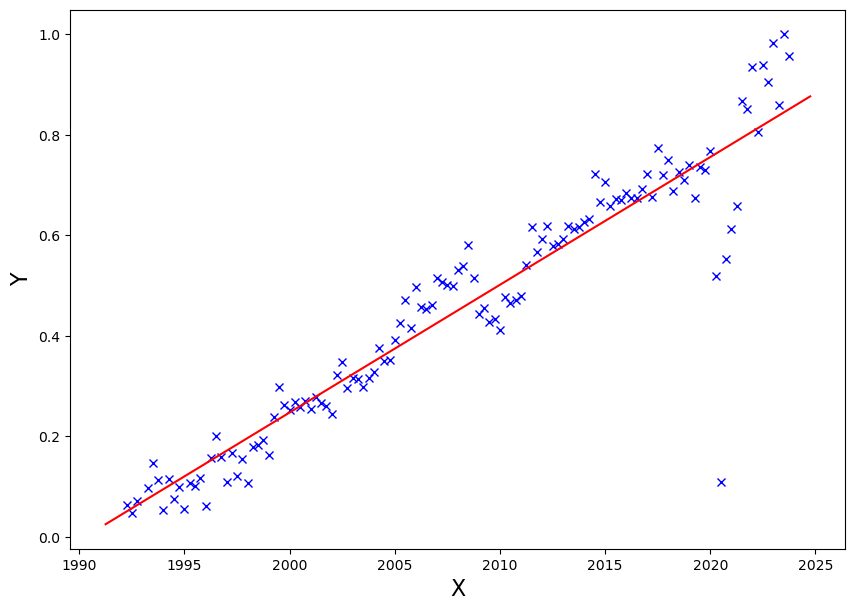

Clothing stores
Coefficients are:
[-5.16404656e+01  2.59389814e-02]
MSE =  8.444054870348312e-05


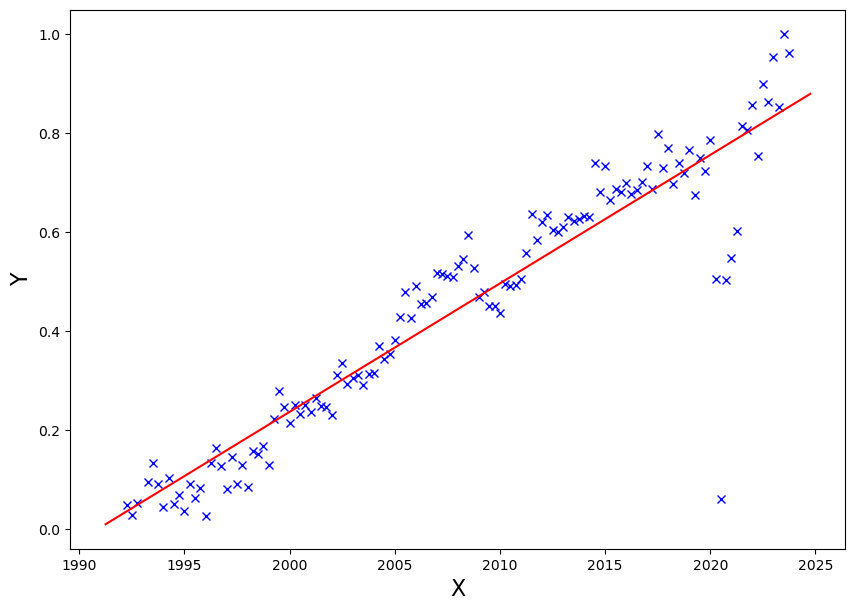

Men's clothing stores
Coefficients are:
[ 2.50480493e+01 -1.20987632e-02]
MSE =  0.00038428622363027967


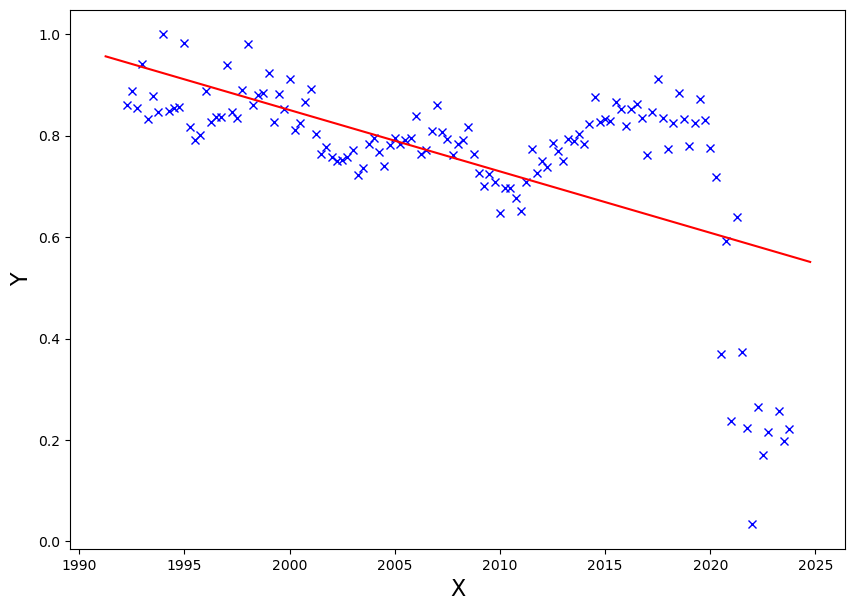

Women's clothing stores
Coefficients are:
[-2.96789599e+01  1.51398475e-02]
MSE =  0.0003299427841009643


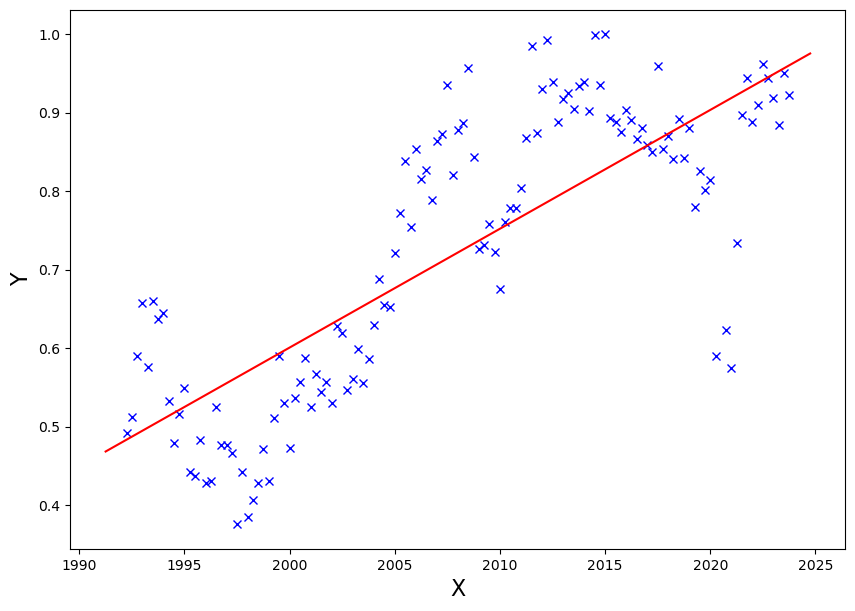

Family clothing stores
Coefficients are:
[-4.88769059e+01  2.45764993e-02]
MSE =  5.770227389256568e-05


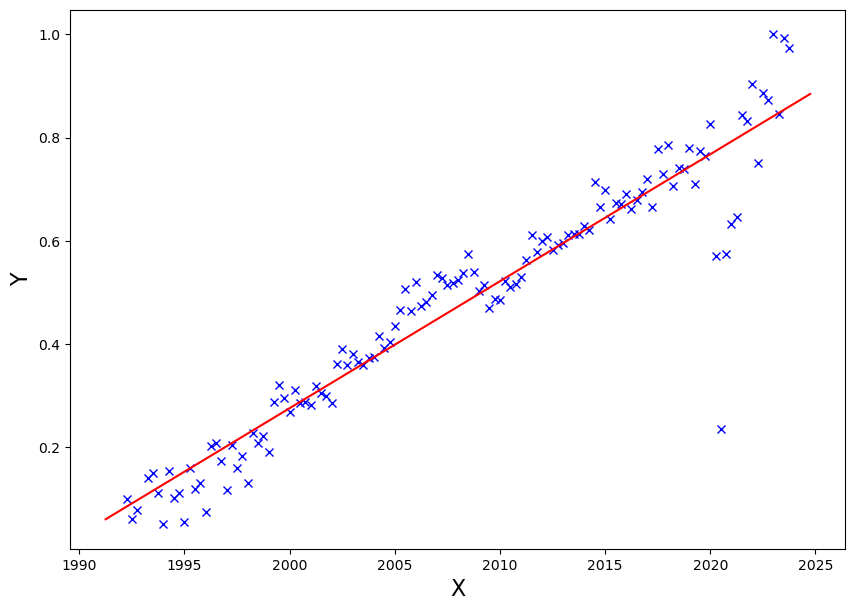

Other clothing stores
Coefficients are:
[-5.77636620e+01  2.90230311e-02]
MSE =  0.00033457079076850516


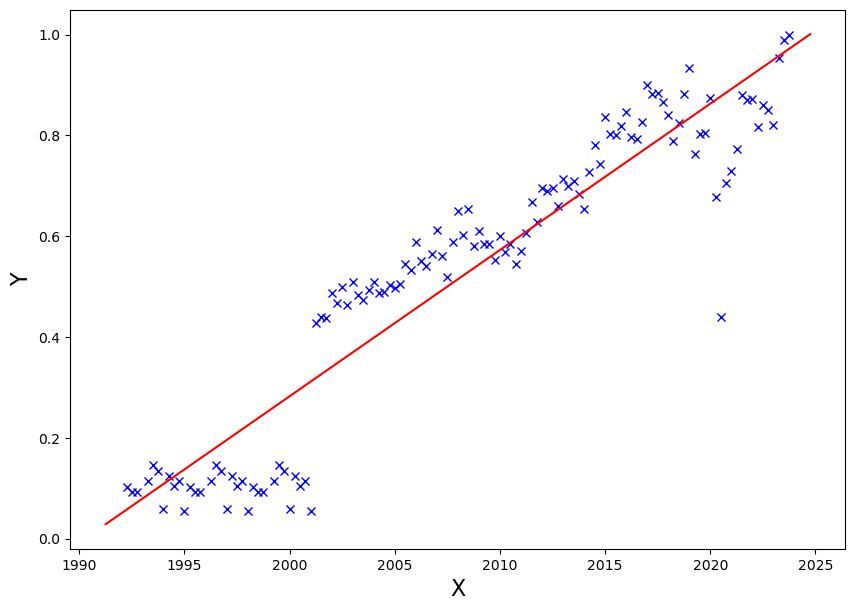

Shoe stores
Coefficients are:
[-5.69032056e+01  2.85538356e-02]
MSE =  0.00023865173968650252


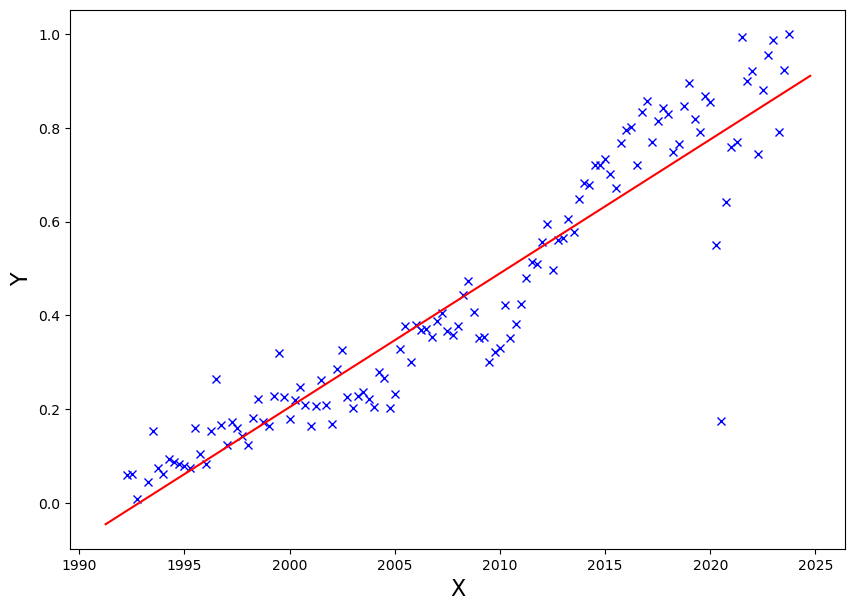

Jewelry stores
Coefficients are:
[-3.65338000e+00  2.19567649e-03]
MSE =  0.0005562709809787662


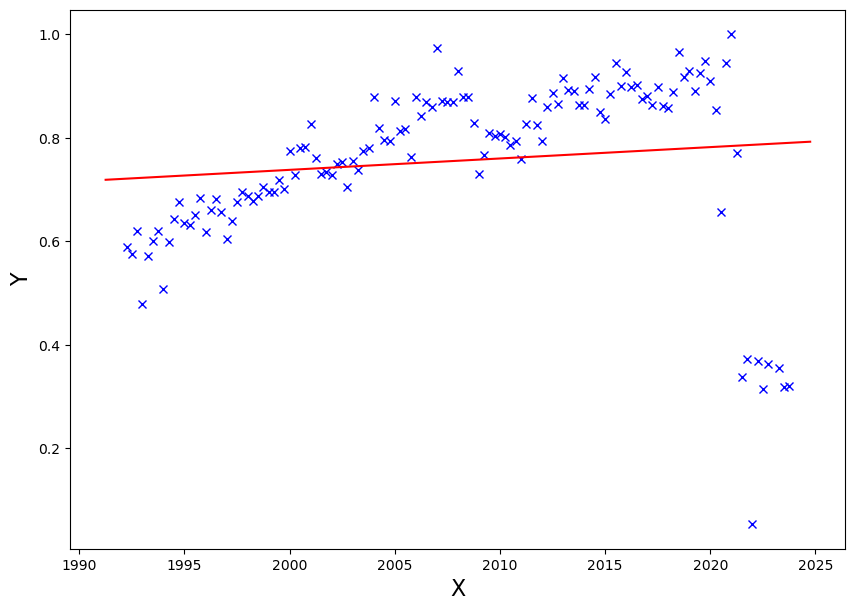

Sporting goods, hobby, musical instrument, and book stores
Coefficients are:
[-4.41262606e+01  2.22231785e-02]
MSE =  0.0001644372853739477


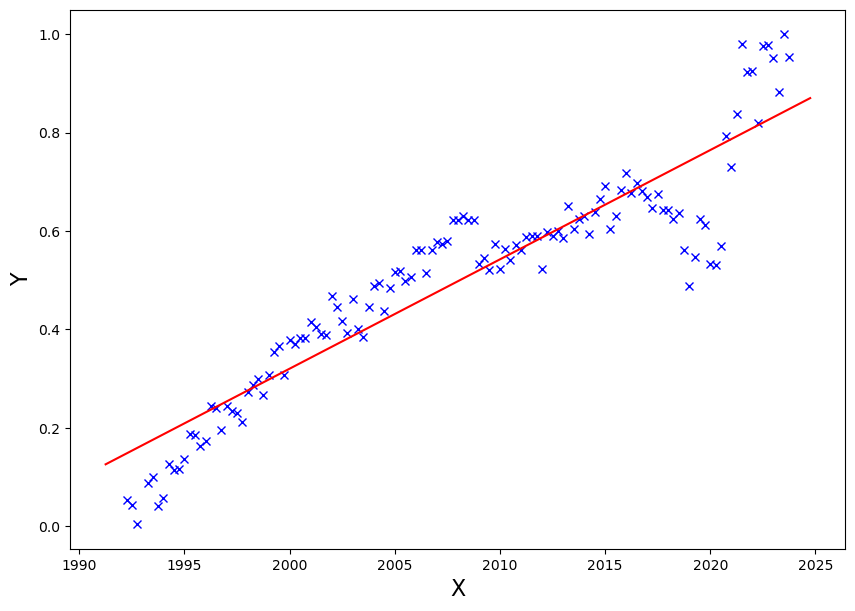

Sporting goods stores
Coefficients are:
[-5.38729927e+01  2.70300244e-02]
MSE =  0.000193914106901817


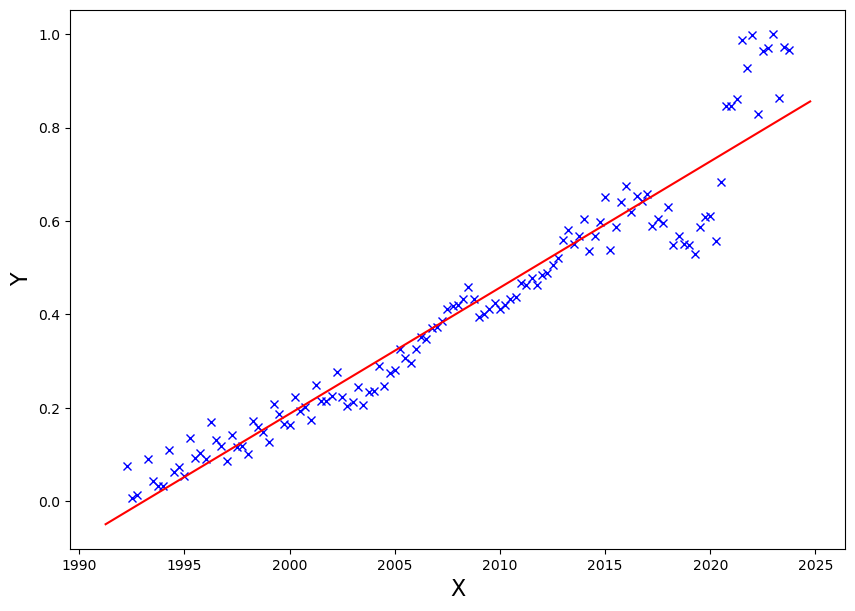

Hobby, toy, and game stores
Coefficients are:
[-2.94935496e+01  1.49056251e-02]
MSE =  0.0006220541699734359


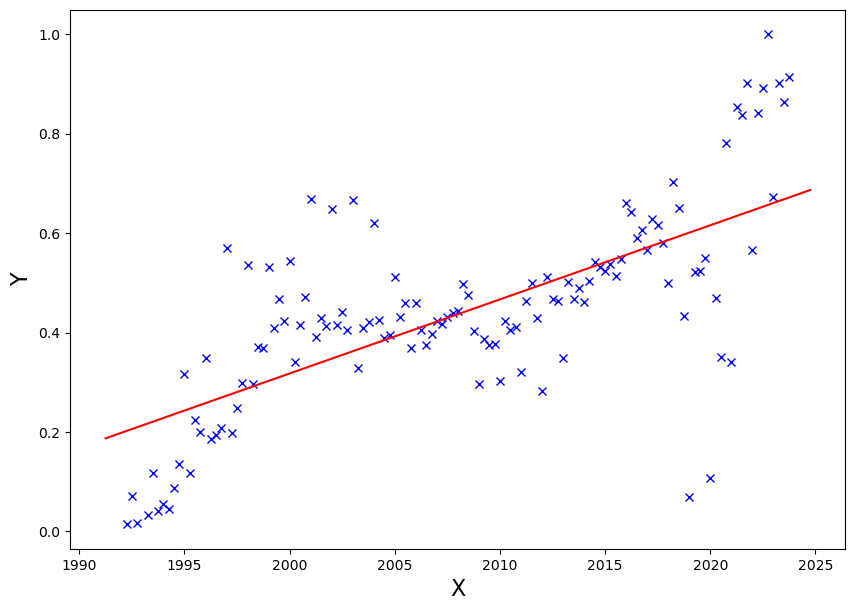

Book stores
Coefficients are:
[-1.05425733e+04  1.05105743e+01 -2.61947309e-03]
MSE =  0.000331016231384231


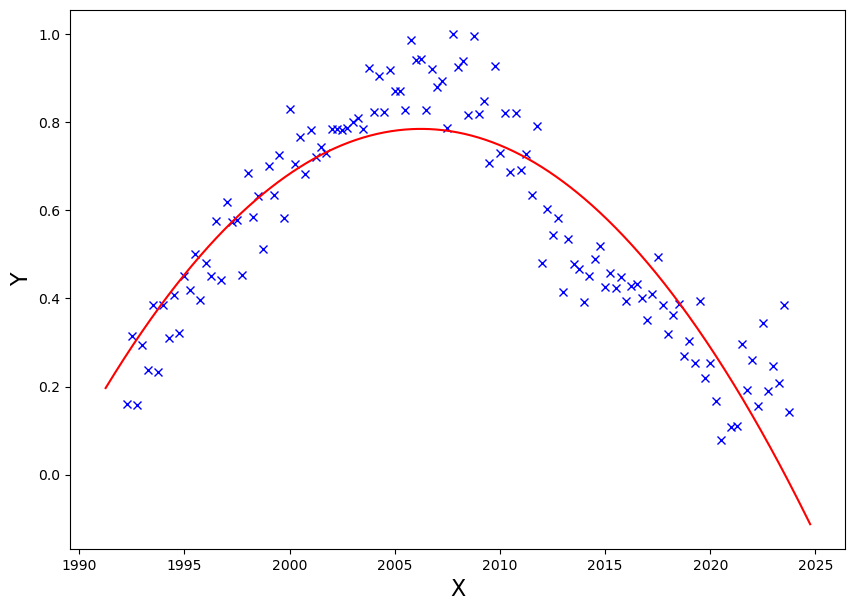

General merchandise stores
Coefficients are:
[-5.65917688e+01  2.84145619e-02]
MSE =  2.7245888795822904e-05


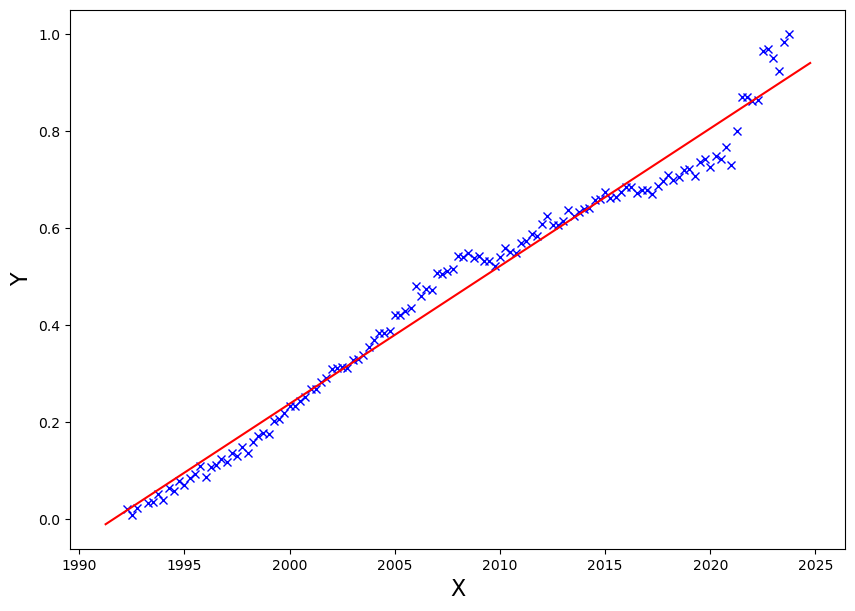

Department stores
Coefficients are:
[ 3.82398985e+01 -1.87367295e-02]
MSE =  0.0007580731968122496


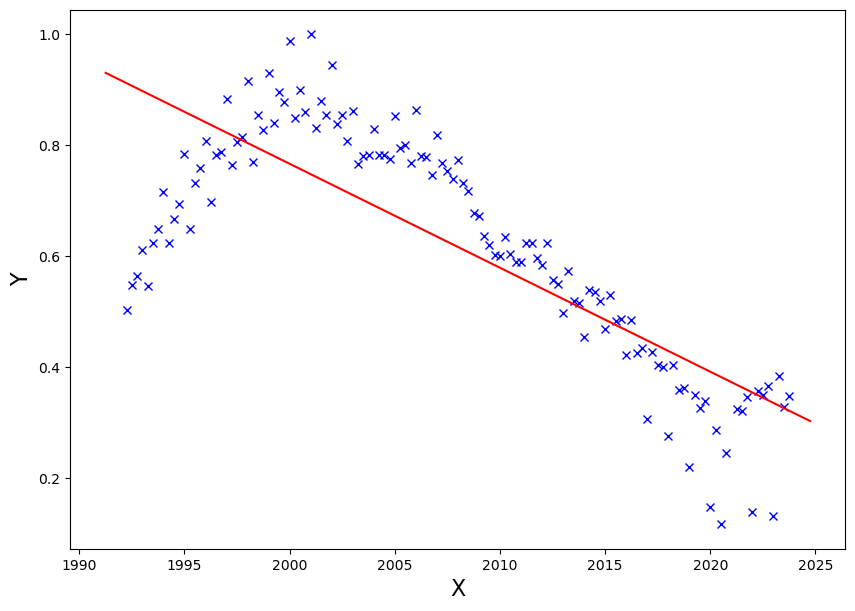

Department stores(excl. discount department stores)
Coefficients are:
[ 4.40561331e+01 -2.16225407e-02]
MSE =  0.0003390461487935068


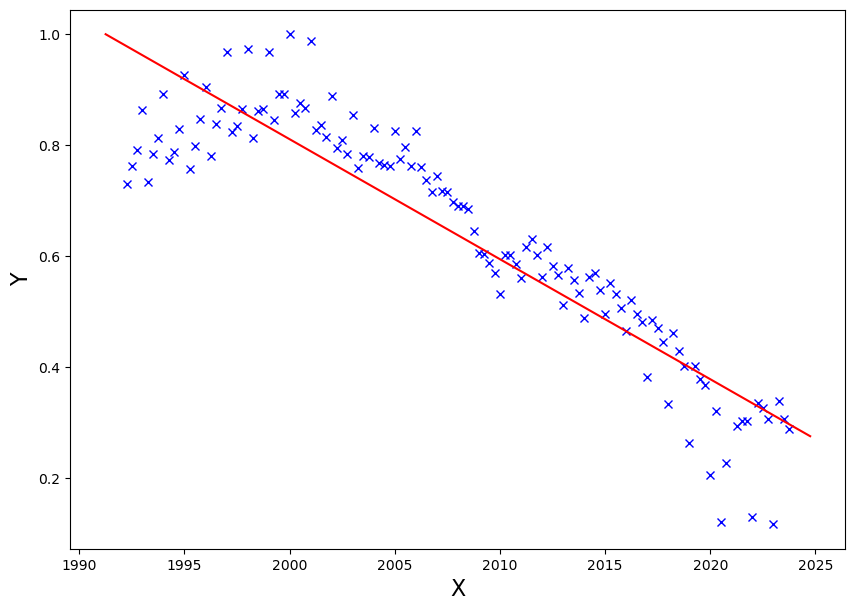

Discount dept. stores
Coefficients are:
[-8.13528967e+03  8.11590957e+00 -2.02395847e-03]
MSE =  0.0006973215234222251


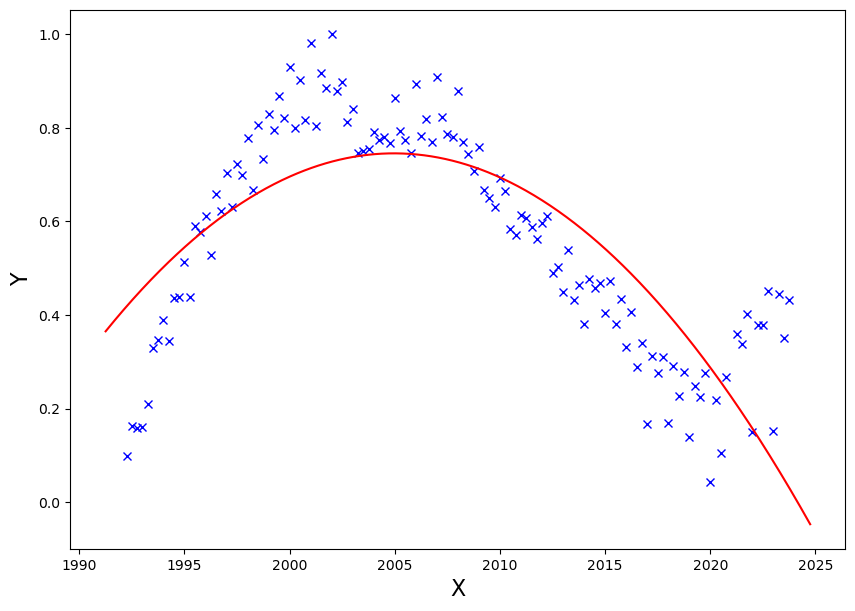

Other general merchandise stores
Coefficients are:
[-6.20319091e+01  3.11083142e-02]
MSE =  4.012683100361799e-05


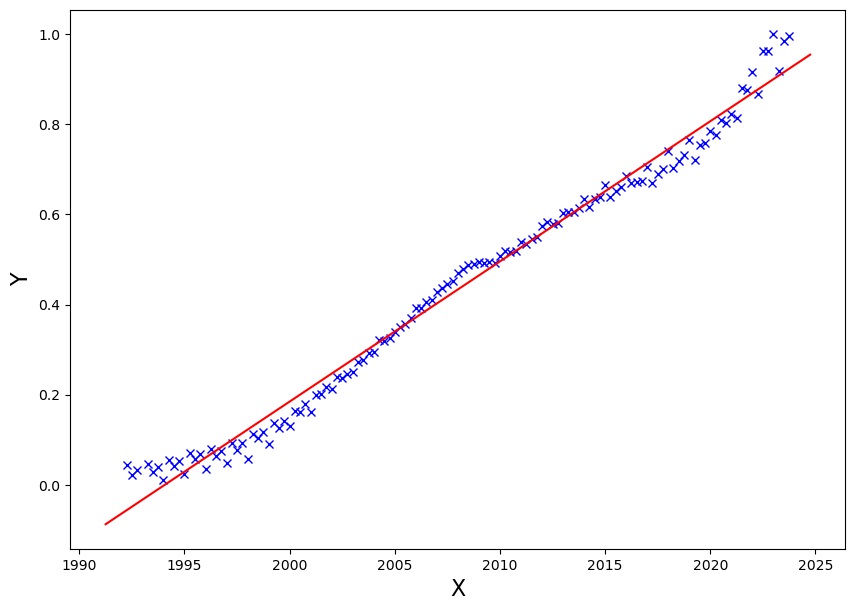

Warehouse clubs and superstores
Coefficients are:
[-6.15785494e+01  3.08915006e-02]
MSE =  3.9103488330238356e-05


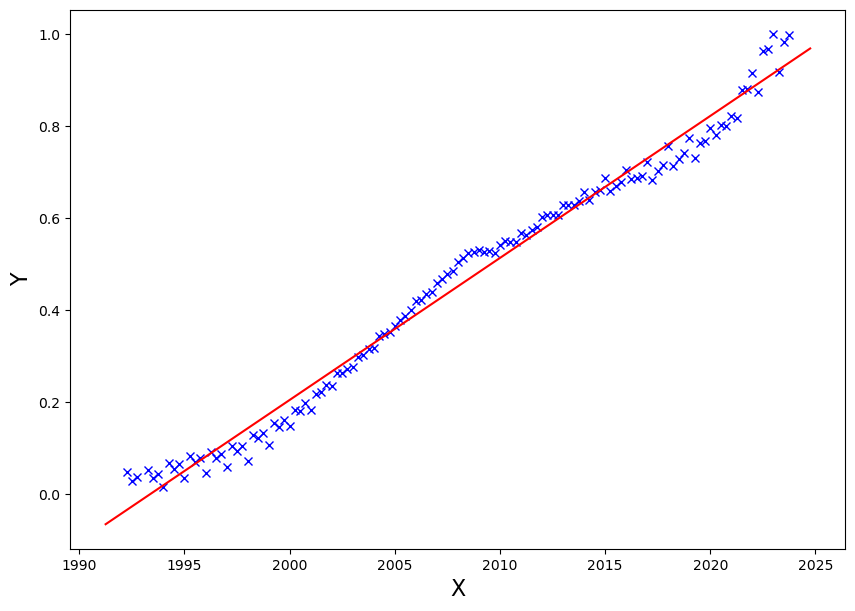

All other gen. merchandise stores
Coefficients are:
[-5.97158480e+01  2.99006061e-02]
MSE =  0.0003121763177547928


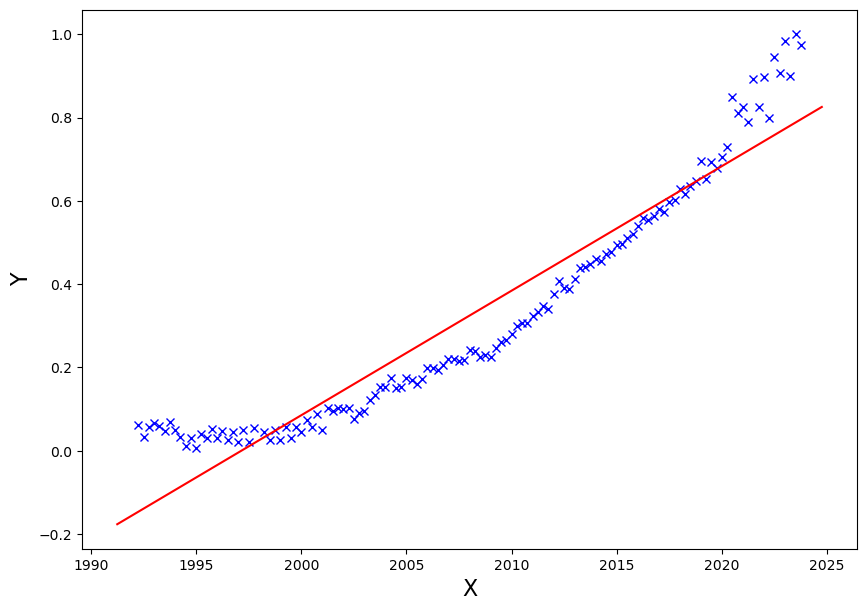

Miscellaneous store retailers
Coefficients are:
[-3.48759015e+01  1.75699108e-02]
MSE =  0.00021806573617115082


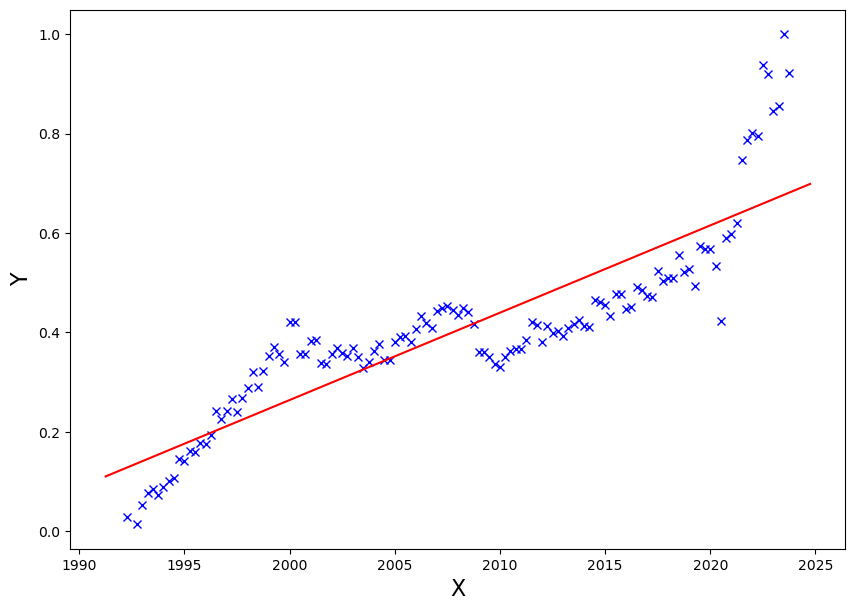

Office supplies, stationery, and gift stores
Coefficients are:
[-8.57529996e+03  8.54416145e+00 -2.12809762e-03]
MSE =  0.0007384306228014172


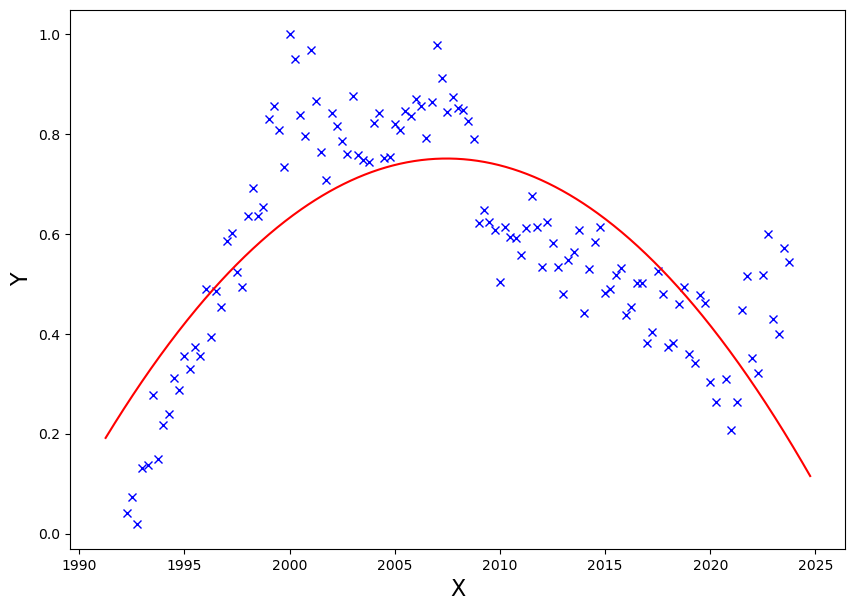

Office supplies and stationery stores
Coefficients are:
[-1.30039054e+04  1.29646891e+01 -3.23119278e-03]
MSE =  0.00043498560031920253


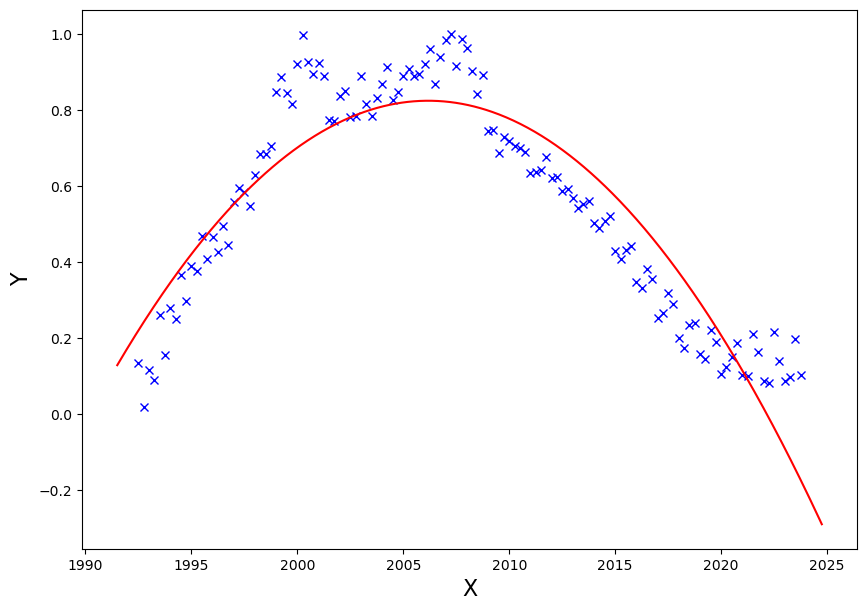

Gift, novelty, and souvenir stores
Coefficients are:
[-1.72564412e+01  8.85760210e-03]
MSE =  0.0006054322608612842


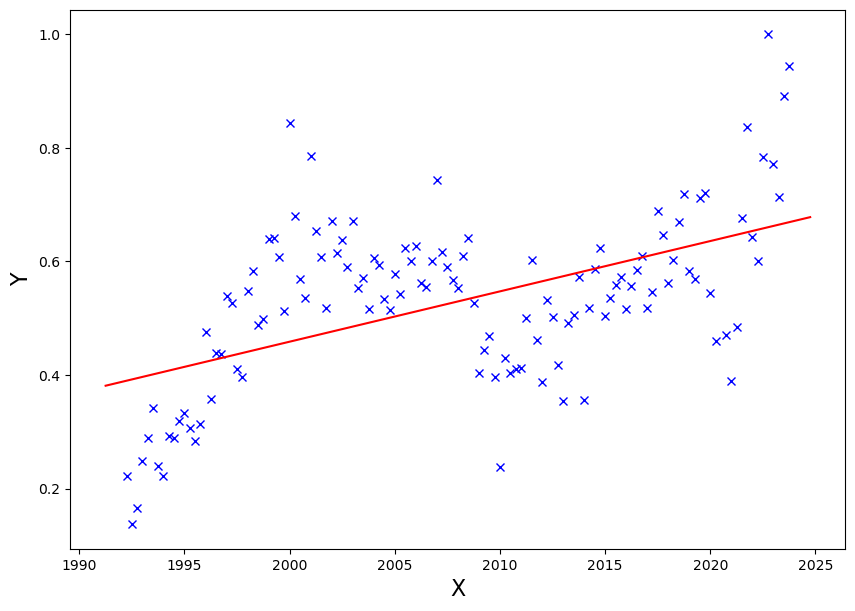

Used merchandise stores
Coefficients are:
[-4.77581784e+01  2.39499879e-02]
MSE =  0.00017958172587619178


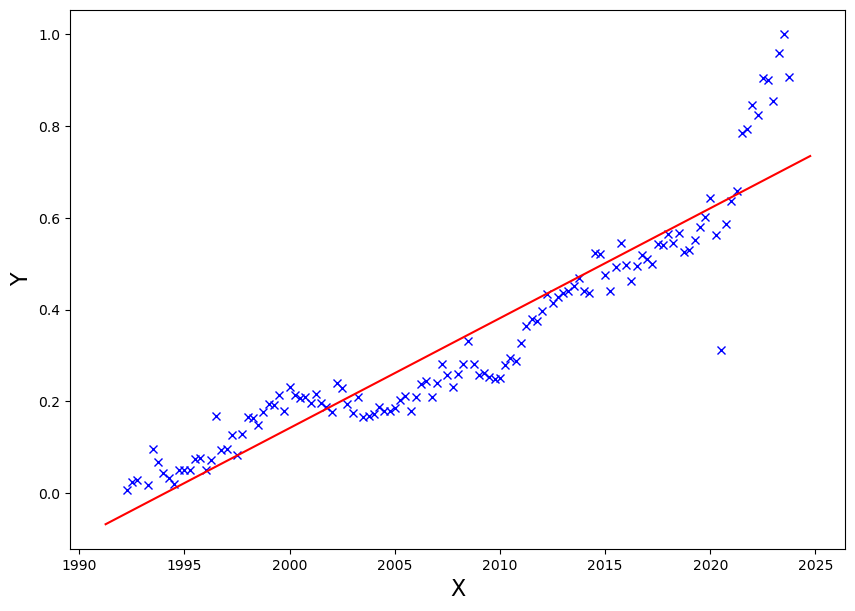

Nonstore retailers
Coefficients are:
[-4.90206879e+01  2.45446849e-02]
MSE =  0.0003662068148062878


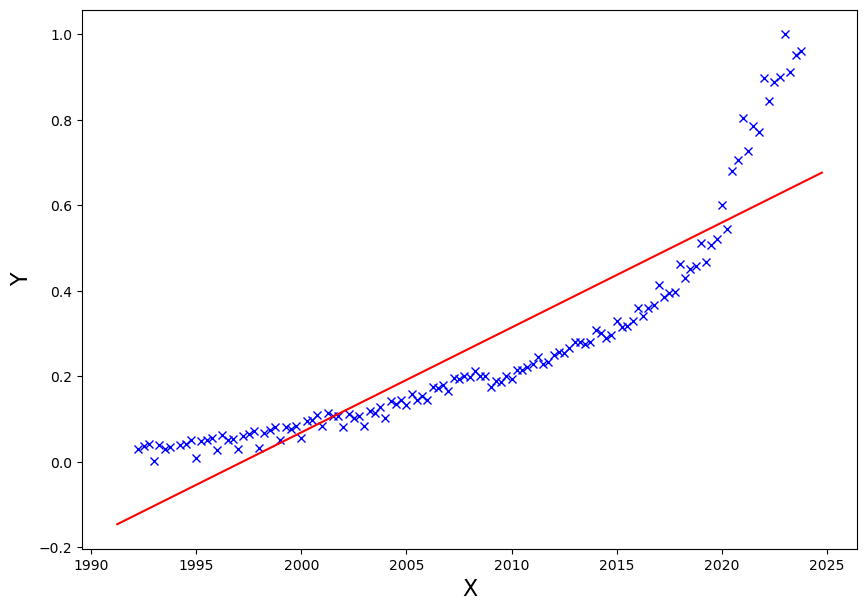

Electronic shopping and mail-order houses
Coefficients are:
[-4.93542096e+01  2.47064440e-02]
MSE =  0.000415122906306017


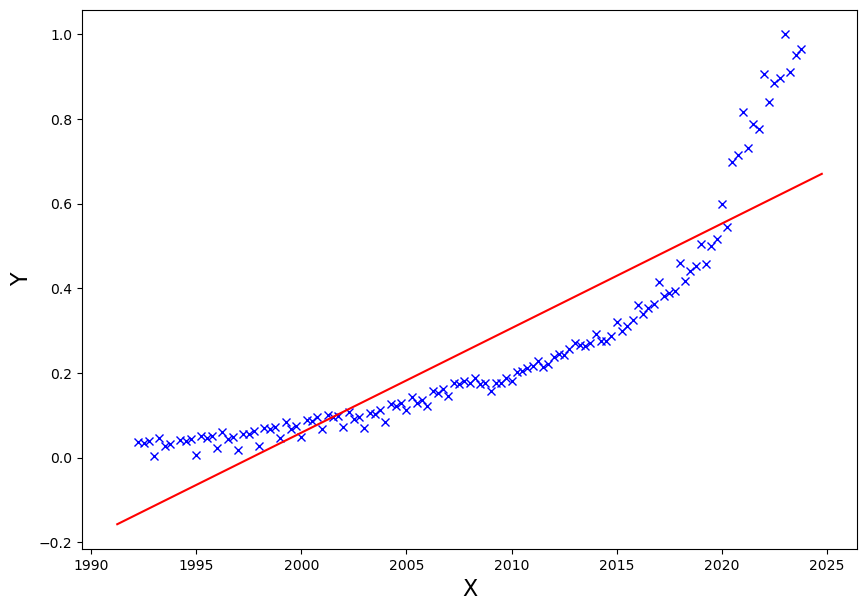

Fuel dealers
Coefficients are:
[-2.79701970e+01  1.41664142e-02]
MSE =  0.000496802921461622


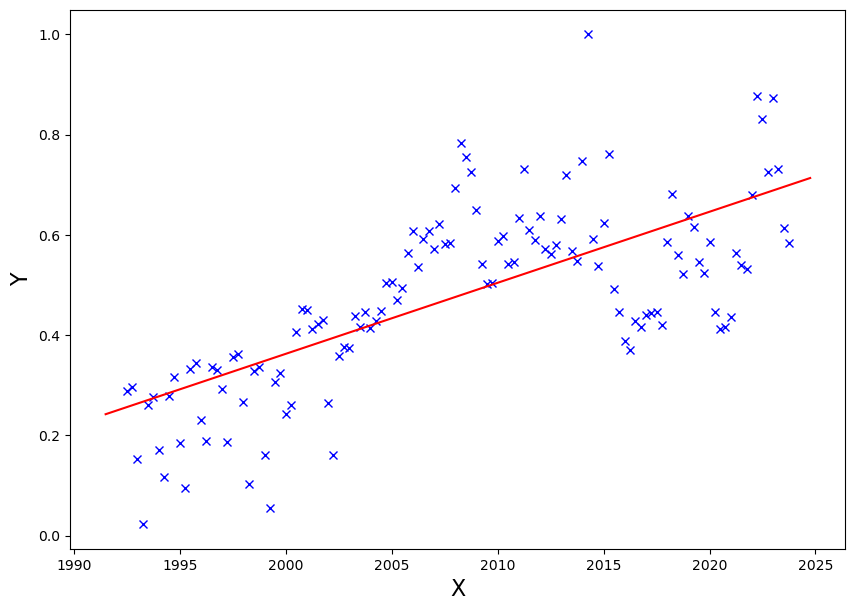

Food services and drinking places
Coefficients are:
[-4.97263250e+01  2.49188817e-02]
MSE =  0.00010833026226256411


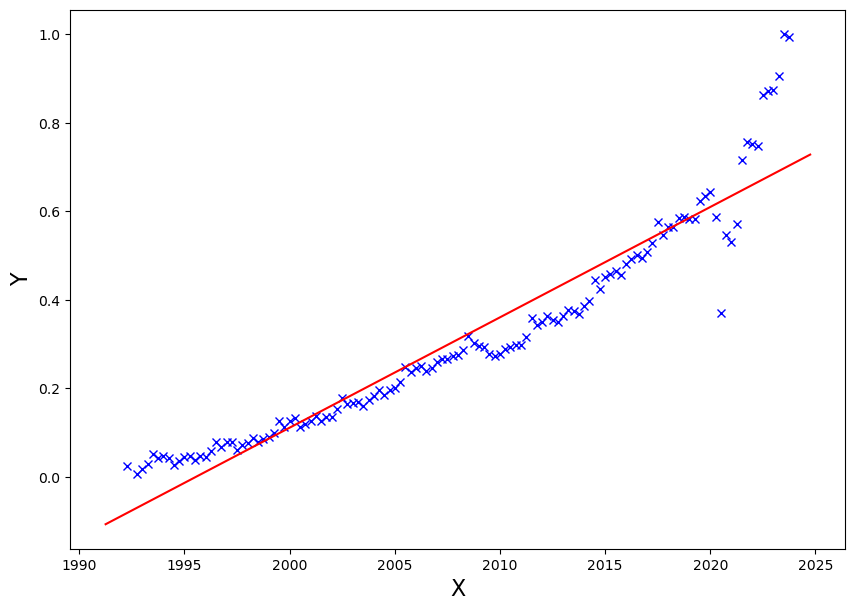

Drinking places
Coefficients are:
[-1.15426906e+04  1.15052570e+01 -2.86677672e-03]
MSE =  0.0013553868627114891


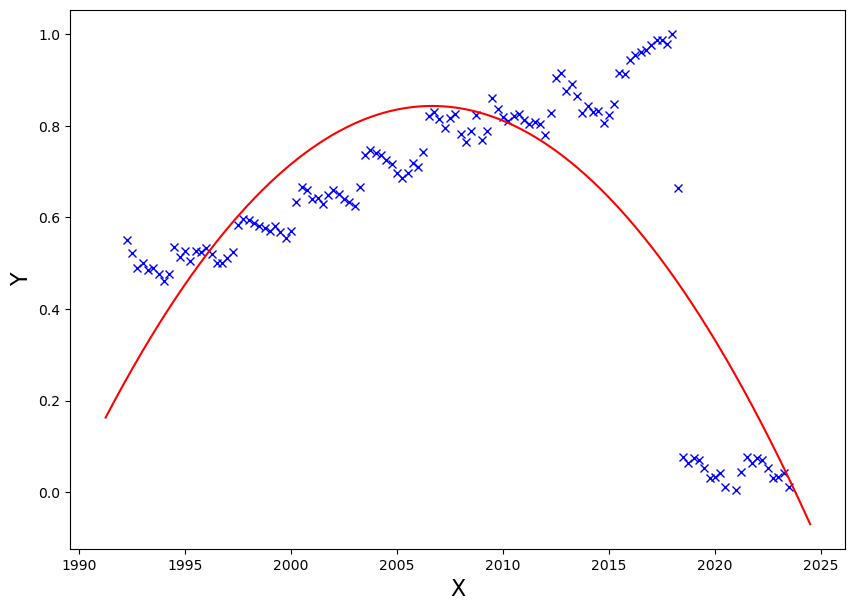

Restaurants and other eating places
Coefficients are:
[-4.96788081e+01  2.48936573e-02]
MSE =  0.0001322301734921409


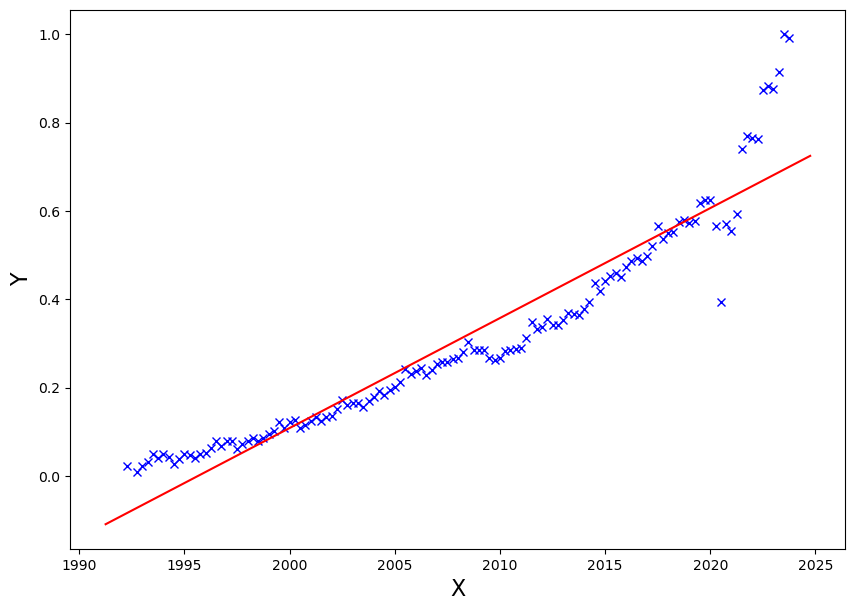

Full service restaurants
Coefficients are:
[-1.51833095e+01  7.82167829e-03]
MSE =  0.0016880259649879124


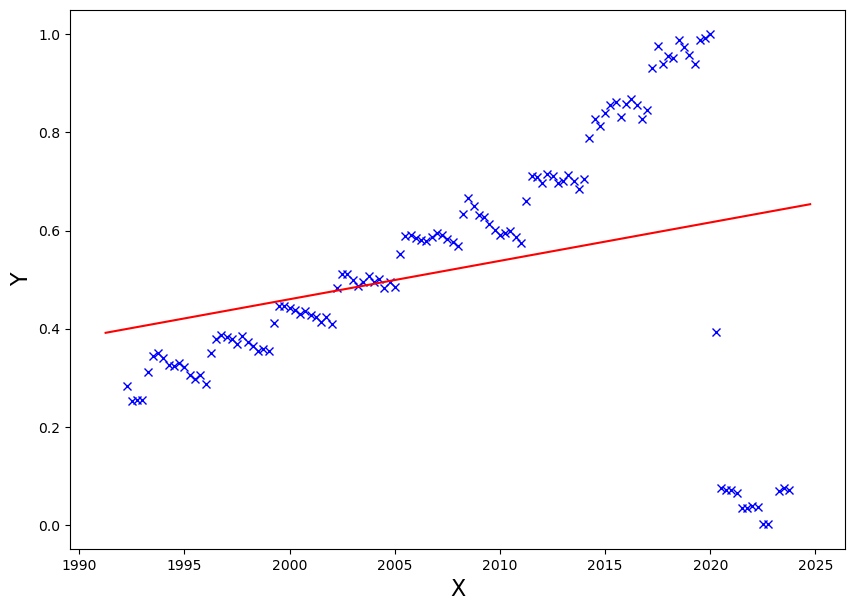

Limited service eating places
Coefficients are:
[-5.08862031e+01  2.54933872e-02]
MSE =  0.00016431345074485152


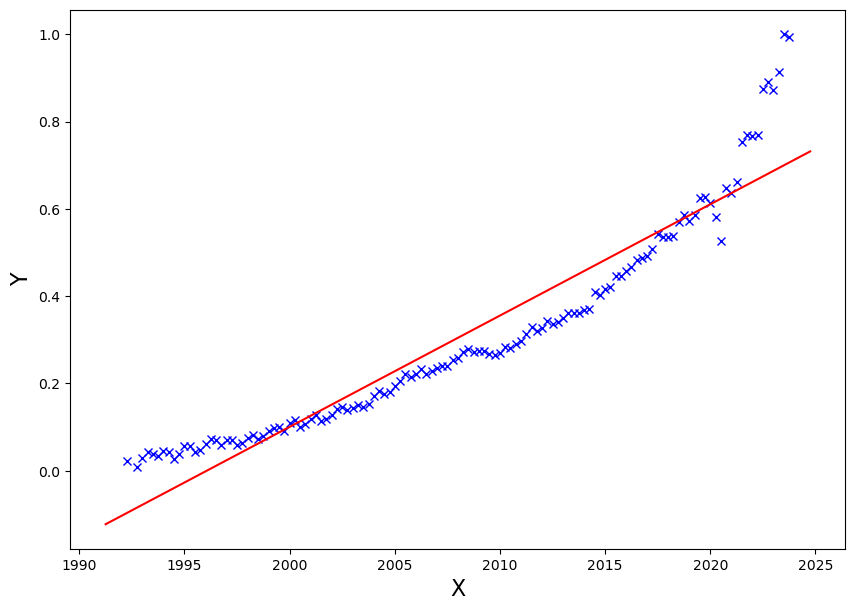

GDP
Coefficients are:
[-2.56656628e+01  1.31186265e-02]
MSE =  5.606124895935851e-05


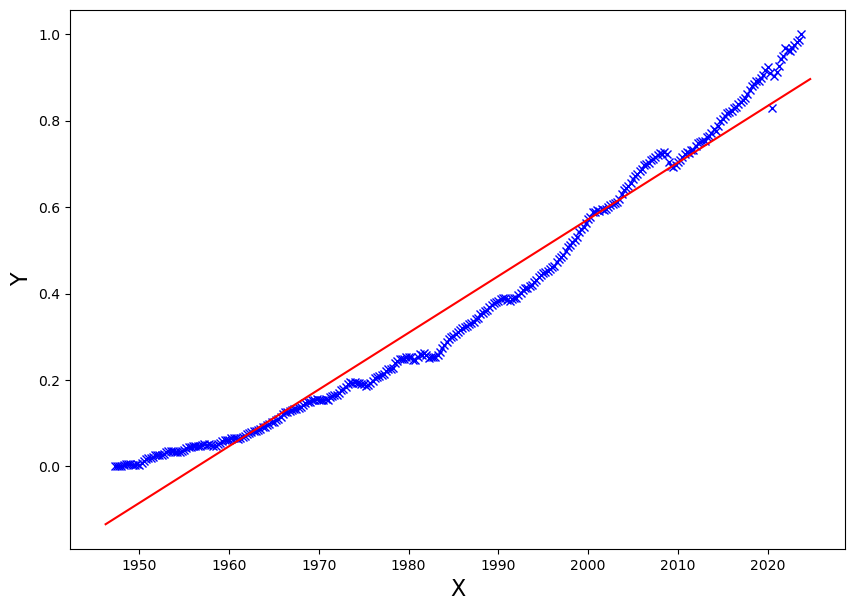

Zillow
Coefficients are:
[-5.38451081e+01  2.69340087e-02]
MSE =  0.000759813541903349


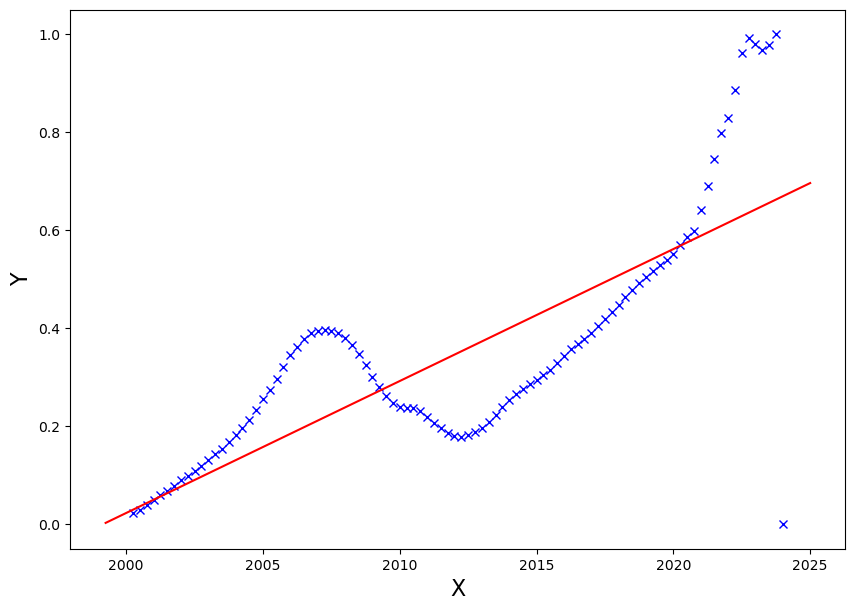

Coffee


NameError: name 'Coffee_y' is not defined

In [33]:
### Polynomial Regression

def GenReg(fullX,fullY):
    # Split the data into training and testing sets
    trainX, testX, trainY, testY = train_test_split(fullX, fullY, test_size=0.2, random_state=42)
    MSE = 1
    degree = 0
    newTrainX = np.array([])
    trainX=np.vstack([np.ones(len(trainX)),trainX])
    prev_MSE = 10
    theta = 0
    converge = True
    while MSE >=0.002 and converge:
        degree+=1
        trainX_degree = trainX
        prev_MSE = MSE
        for i in range(degree-1):
            trainX_degree=np.vstack([trainX_degree,np.power(trainX_degree[1,:],i+2)])
        theta=(np.linalg.solve(np.matmul(trainX_degree,trainX_degree.T),np.matmul(trainX_degree,trainY)))
        
        
        newTrainX=np.zeros(shape=(degree+1,700))
        i = 0
        for row in trainX_degree:
            row=np.linspace(np.min(row),np.max(row),700)
            if i == 1:
                row = np.linspace(np.min(fullX)-1,np.max(fullX)+1,700)
            if(i>1):
                row = np.power(newTrainX[1],i)
            newTrainX[i] = row
            i+=1
        
        # Testing on points
        test = np.zeros(shape=(len(testX),degree+1))
        for i in range(degree+1):
            for j in range(len(testX)):
                test[j][i]=pow(testX[j],i)


        MSE = np.linalg.norm(np.matmul(test,theta) - testY)**2/pow(len(testY),2)
        if MSE/prev_MSE > 1.5:
            degree-=1
        elif MSE == prev_MSE:
            converge = False
        
    print("Coefficients are:")
    print(theta)
    print("MSE = ",MSE)
    Y_pred = np.matmul(newTrainX.T,theta)  # calculating the regression line

    fig, ax = plt.subplots()  # ax refers to the picture, fig refers to an invisible container around it
    fig.set_size_inches(10, 7) 

    ax.set_xlabel("X", fontsize=16)
    ax.set_ylabel("Y", fontsize=16)

    ax.plot(fullX,fullY,'x',color='Blue')  # scatter plot of data
    plt.plot(newTrainX.T[:,1],Y_pred, color='red') # regression line

    plt.show()
    return MSE

# Keep track of error: 
errors = []

# Census
n = 0
for row in census_y:
    print(census_names[n])
    temp_x = census_x_interval
    temp_y = row
    i = 0
    for num in temp_y:
        if num == 0:
            temp_x = np.delete(temp_x,i)
            temp_y = np.delete(temp_y,i)
        else:
            i+=1

    errors.append(GenReg(temp_x,temp_y))
    n+=1

# GDP
print("GDP")
errors.append(GenReg(GDP_x_interval,GDP_y))

# Zillow
print("Zillow")
errors.append(GenReg(Zillow_x_interval,Zillow_y))

# Coffee 
print("Coffee")
errors.append(GenReg(Coffee_x_interval,Coffee_y))

# graphing errors
bar_names = census_names.copy()
bar_names.append("GDP")
bar_names.append("Zillow")
bar_names.append("Coffee")
fig = plt.figure(figsize = (20, 5))
plt.bar(bar_names, errors, width = 0.4)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Variables")
plt.ylabel("MSE")
plt.show()

### Ridge Regression

In [66]:
 def ridge_regression(x,y,alpha=1.0, test_size=0.2, random_state=42):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    if len(X_train) == 0:
        raise ValueError("The resulting train set is empty. Adjust test_size or provide more data.")


    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = X_train.reshape(-1,1)
    X_test_scaled = X_test.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    y_train = y_train.reshape(-1,1)

    # Initialize and train the Ridge regression model
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)


    # Make predictions on the test set
    y_pred = ridge_model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    
    # Plot predicted vs actual values
    plt.subplot()
    plt.scatter(X_test_scaled, y_test, label="Actual Values")
    plt.plot(X_test_scaled, y_pred, color='red', linewidth=2, label="Regression Line")
    plt.xlabel("Feature Values")
    plt.ylabel("Target Values")
    plt.title("Ridge Regression: Actual vs Predicted")
    plt.show()
    # get the error for each
    return mse

Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
Pharmacies and drug stores
P

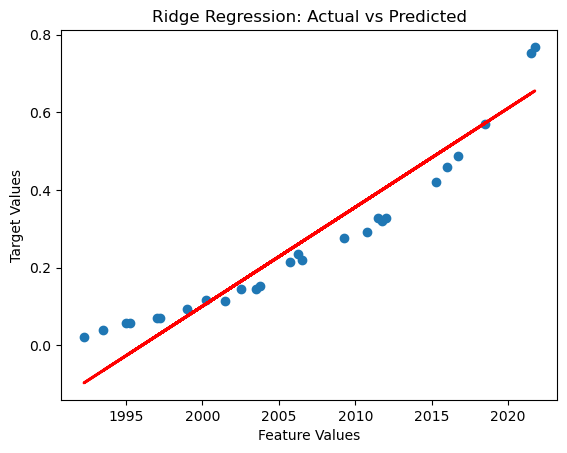

General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
General merchandise stores
G

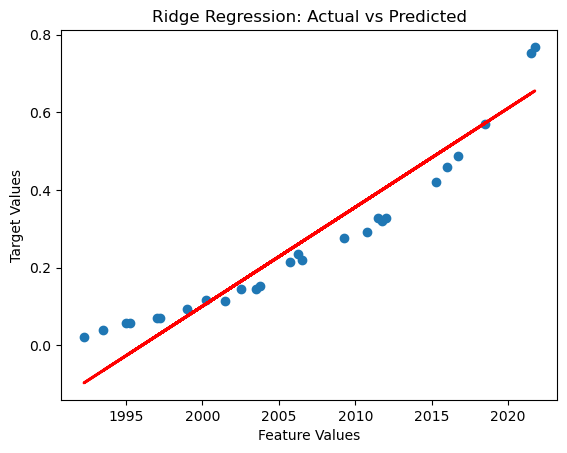

Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health and personal care stores
Health a

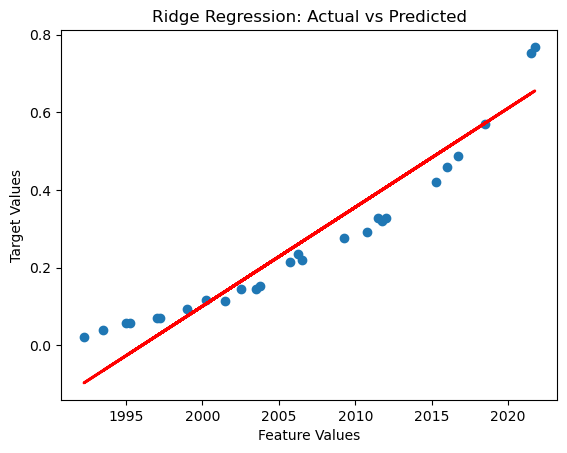

In [67]:
errors = []

census_name = ['Pharmacies and drug stores', 'General merchandise stores', 'Health and personal care stores']

for name in census_name:
    for row in census_y:
        print(name)
        temp_x = census_x_interval
        temp_y = row
        i = 0
        for num in temp_y:
            if num == 0:
                temp_x = np.delete(temp_x,i)
                temp_y = np.delete(temp_y,i)
            else:
                i+=1

    errors.append(ridge_regression(temp_x,temp_y,alpha=1.0, test_size=0.2, random_state=42))
    n+=1
    
        

Motor vehicle and parts dealers
Mean Squared Error: 0.010626008560358408


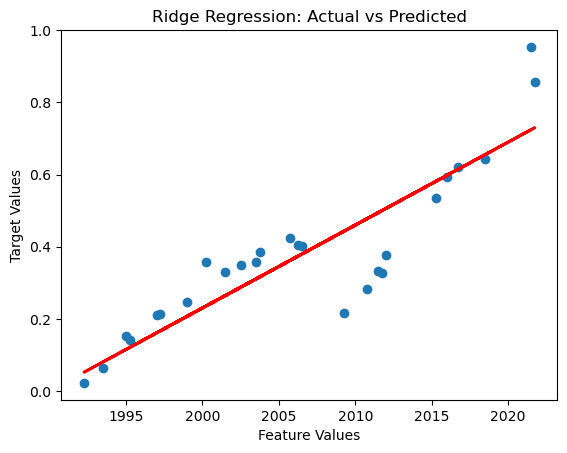

Automobile and other motor vehicle dealers
Mean Squared Error: 0.01204592677728419


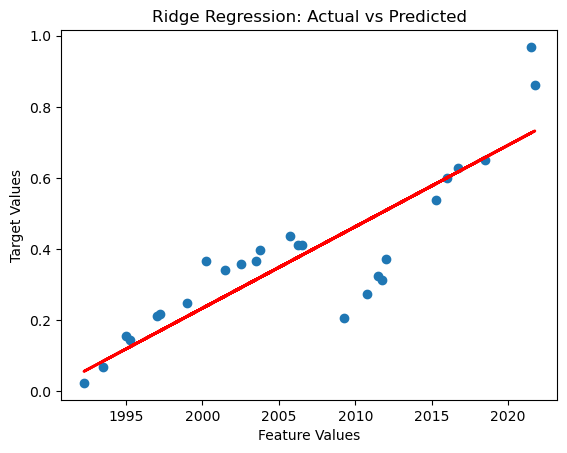

Automobile dealers
Mean Squared Error: 0.01203445158952261


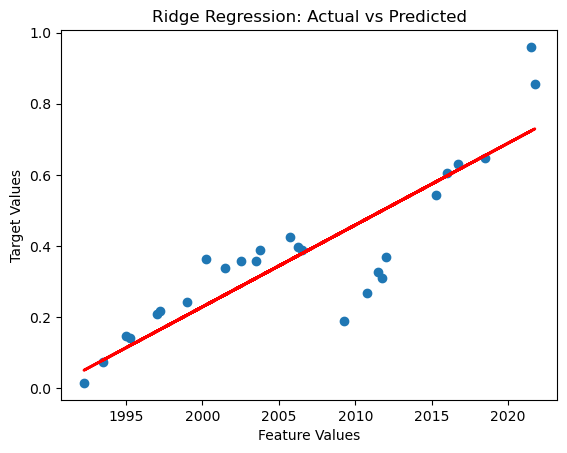

New car dealers
Mean Squared Error: 0.013372163407783246


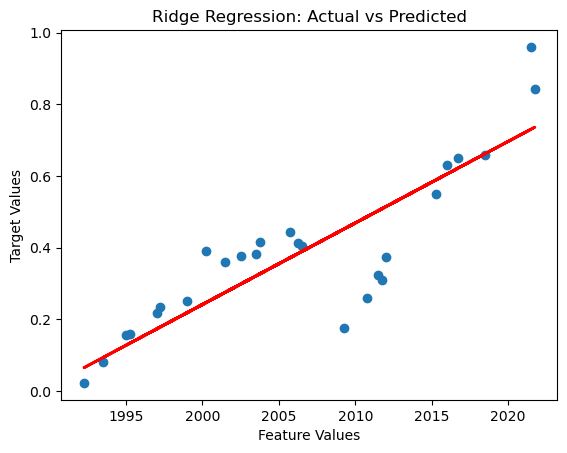

Used car dealers
Mean Squared Error: 0.008150190353167995


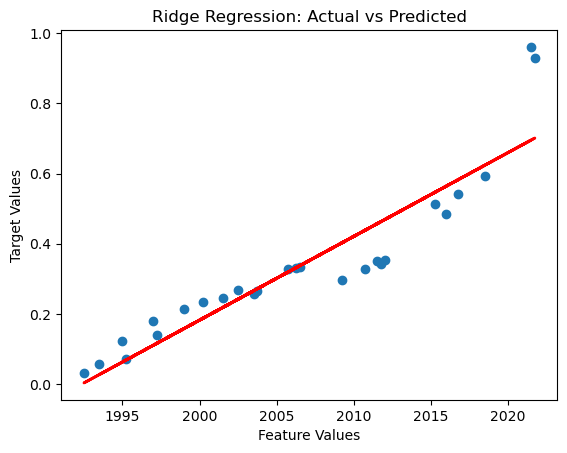

Automotive parts, acc., and tire stores
Mean Squared Error: 0.0015014920812532408


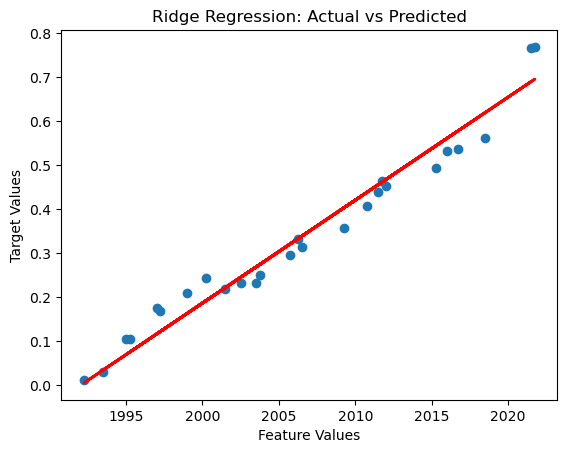

Furniture, home furn, electronics, and appliance stores
Mean Squared Error: 0.014761586855627661


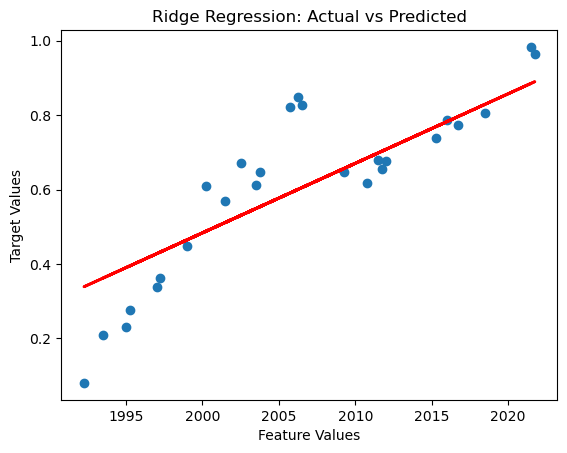

Furniture and home furnishings stores
Mean Squared Error: 0.014596015152599682


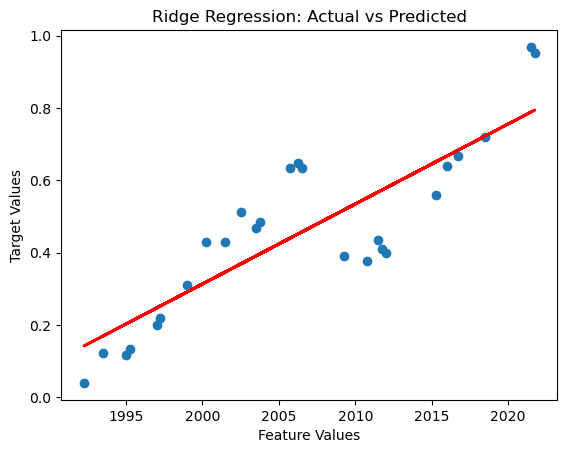

Furniture stores
Mean Squared Error: 0.015215147316172128


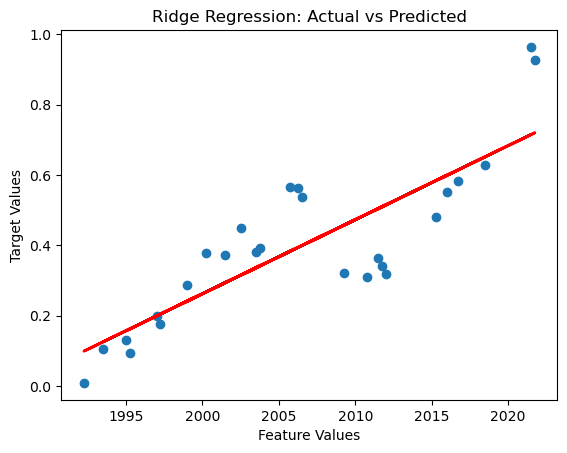

Home furnishings stores
Mean Squared Error: 0.040816691798935927


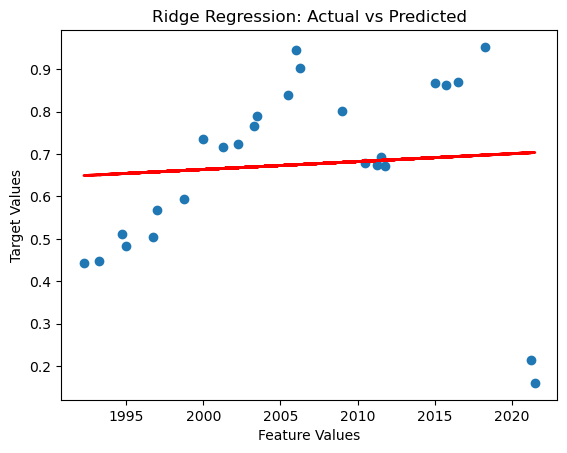

Floor covering stores
Mean Squared Error: 0.06062662143957127


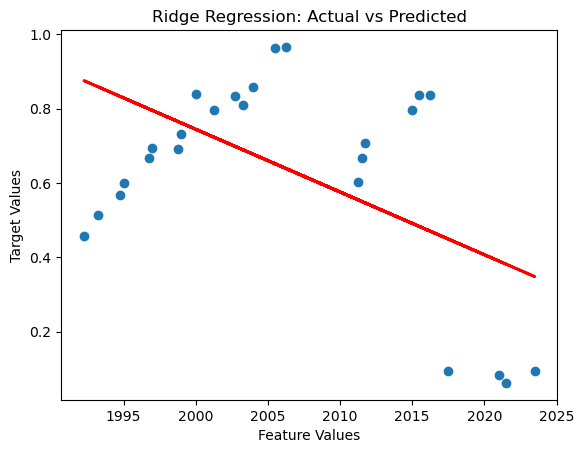

All other home furnishings stores
Mean Squared Error: 0.07493659276990809


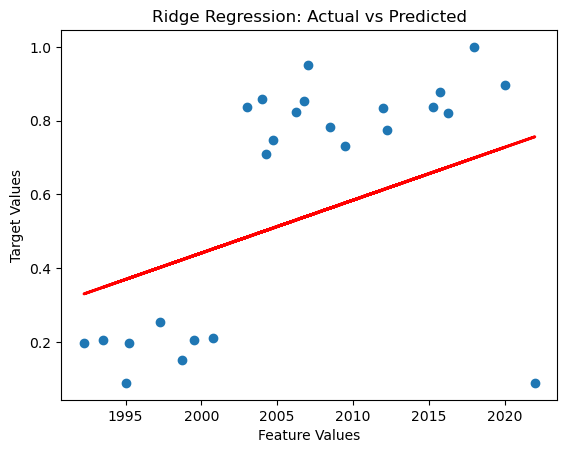

Electronics and appliance stores
Mean Squared Error: 0.02304236232813182


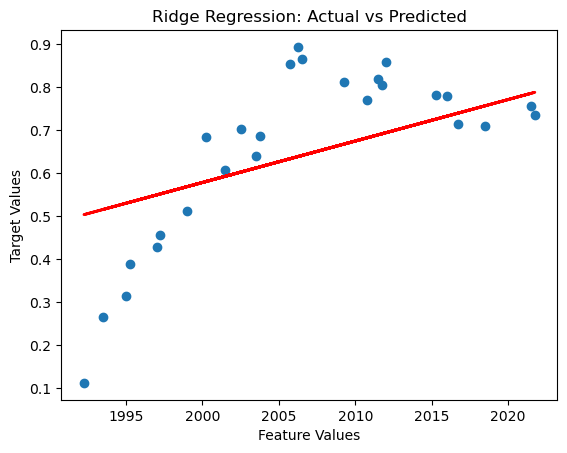

Household appliance stores
Mean Squared Error: 0.00972136362950467


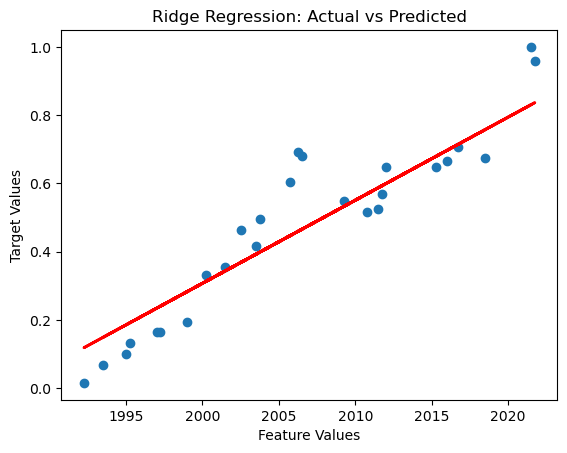

Electronics stores
Mean Squared Error: 0.04265855894635454


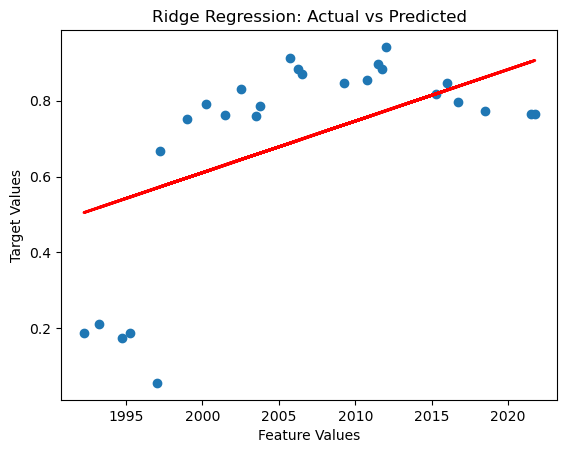

Building mat. and garden equip. and supplies dealers
Mean Squared Error: 0.00946718902689416


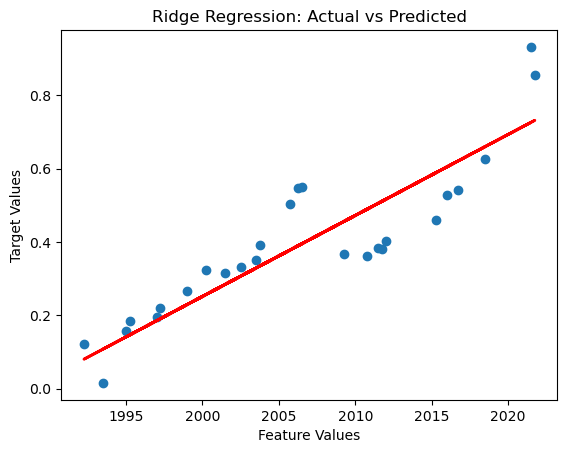

Building mat. and supplies dealers
Mean Squared Error: 0.010136744030596844


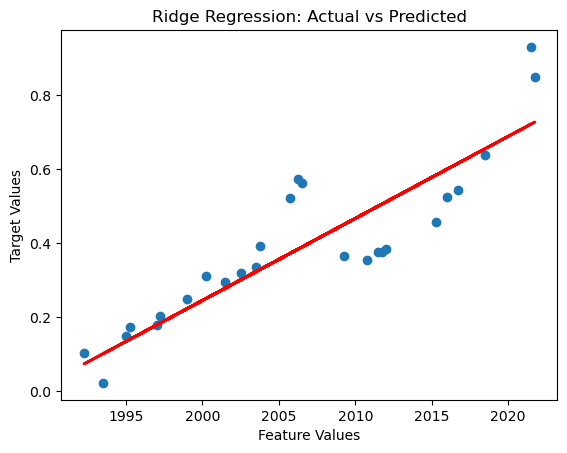

Paint and wallpaper stores
Mean Squared Error: 0.01575834644421913


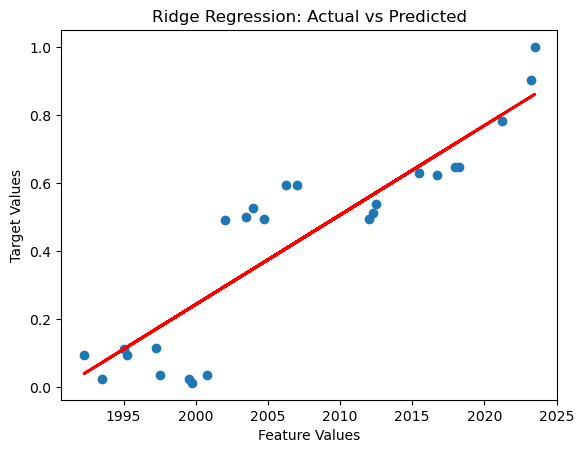

Hardware stores
Mean Squared Error: 0.009159087390693084


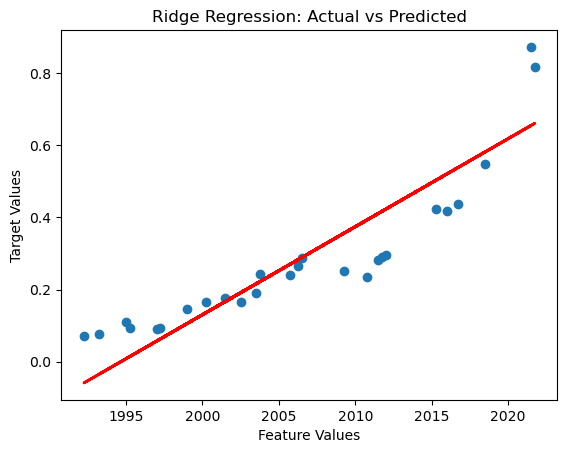

Food and beverage stores
Mean Squared Error: 0.00376708301182641


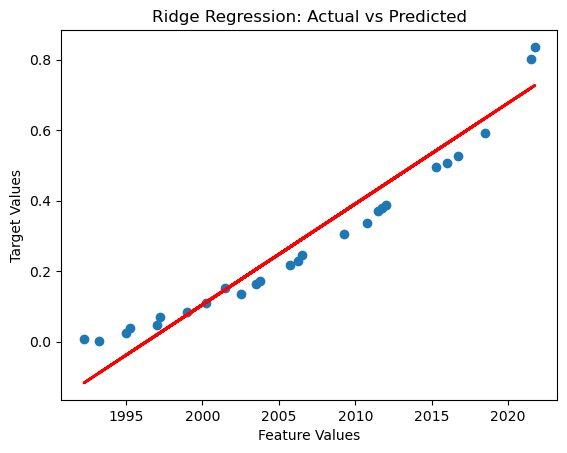

Grocery stores
Mean Squared Error: 0.0037169203928381403


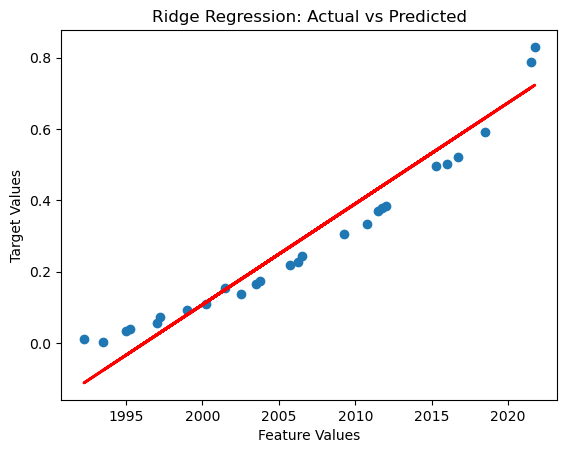

Supermarkets and other grocery (except convenience) stores
Mean Squared Error: 0.011670445583624218


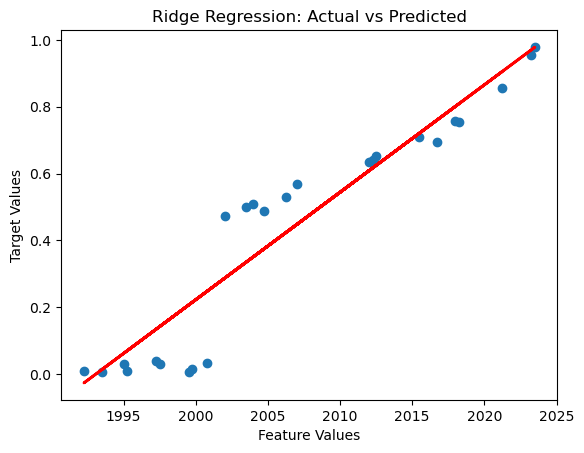

Beer, wine, and liquor stores
Mean Squared Error: 0.005272338314984238


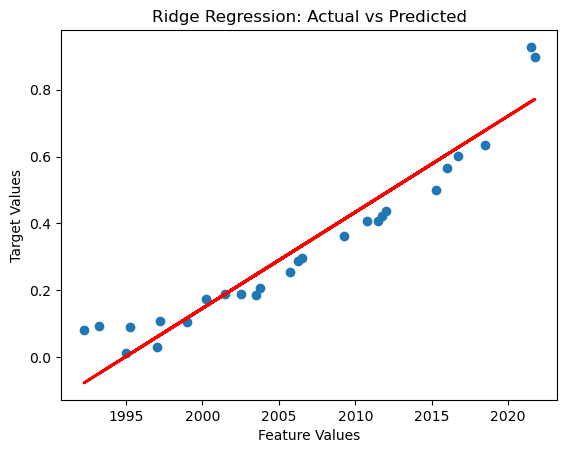

Health and personal care stores
Mean Squared Error: 0.00045233222748346247


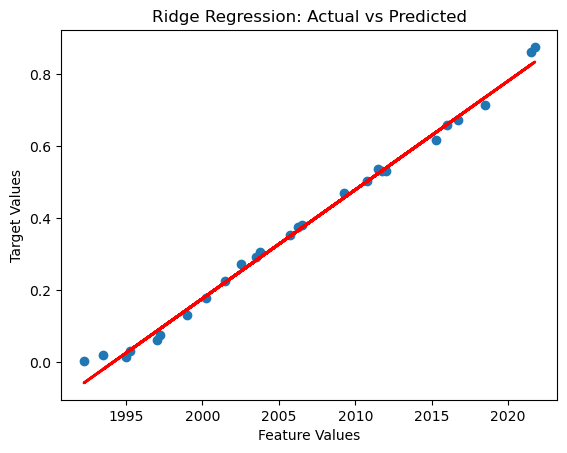

Pharmacies and drug stores
Mean Squared Error: 0.000591337308450191


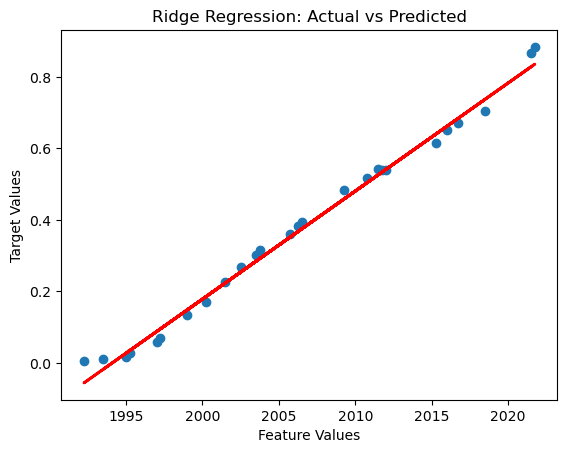

Gasoline stations
Mean Squared Error: 0.0061591515786690205


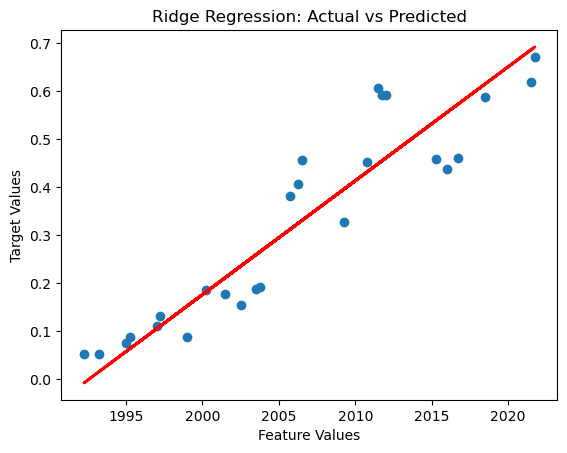

Clothing and clothing access. stores
Mean Squared Error: 0.0017912075344777869


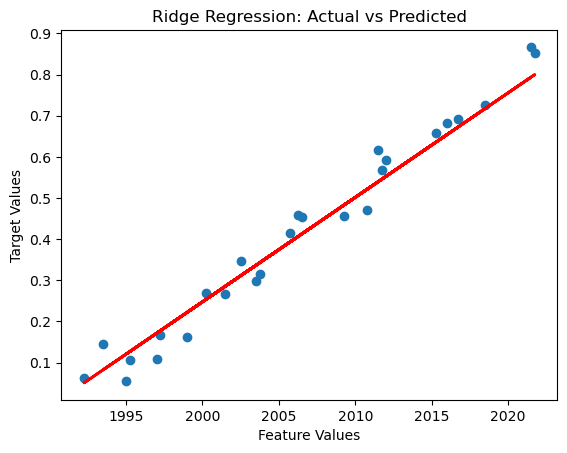

Clothing stores
Mean Squared Error: 0.0021963632077837652


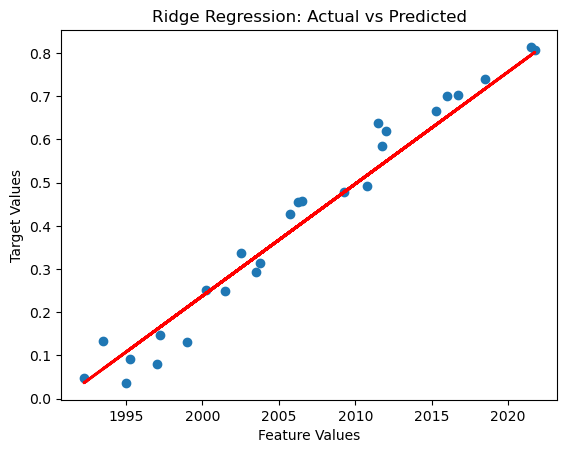

Men's clothing stores
Mean Squared Error: 0.009990611757273088


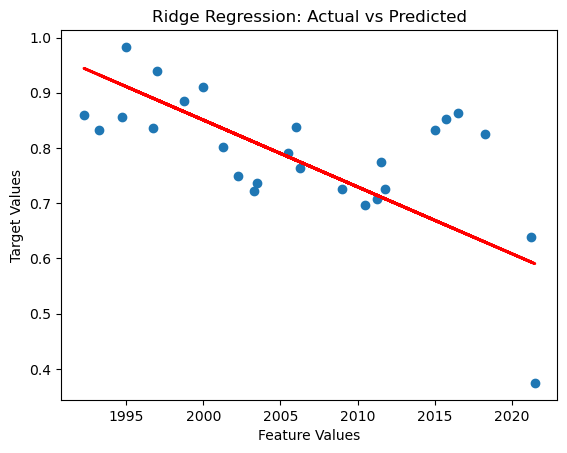

Women's clothing stores
Mean Squared Error: 0.008579155846534818


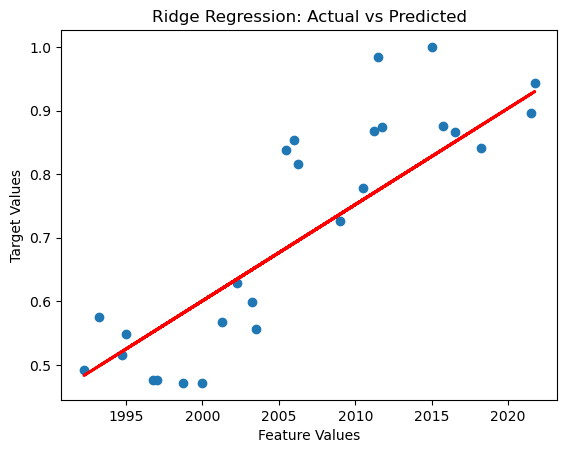

Family clothing stores
Mean Squared Error: 0.0015008424264268871


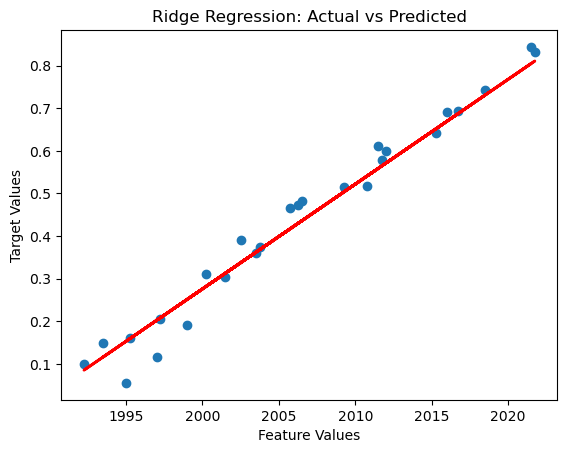

Other clothing stores
Mean Squared Error: 0.008365392071699214


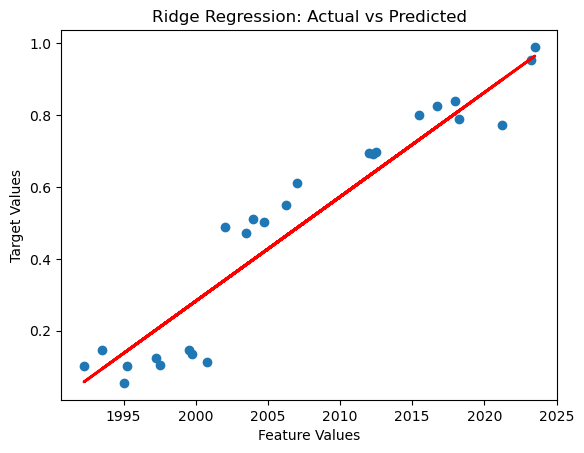

Shoe stores
Mean Squared Error: 0.006205546224021237


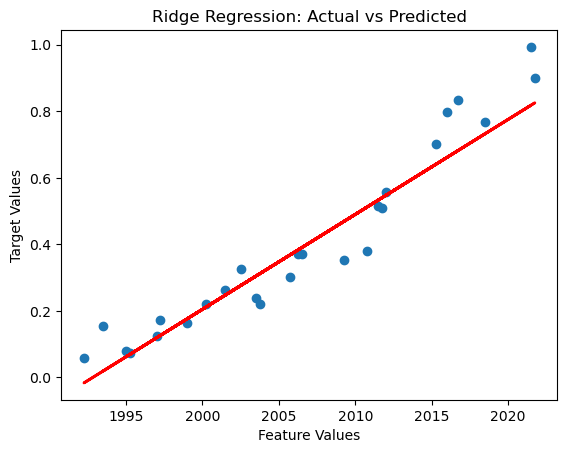

Jewelry stores
Mean Squared Error: 0.014463163936336336


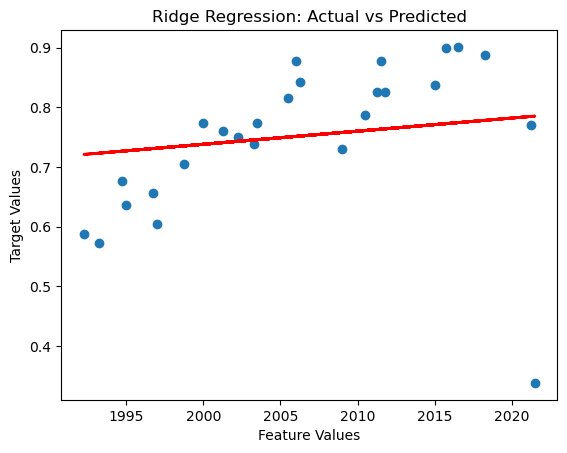

Sporting goods, hobby, musical instrument, and book stores
Mean Squared Error: 0.0042765001911594745


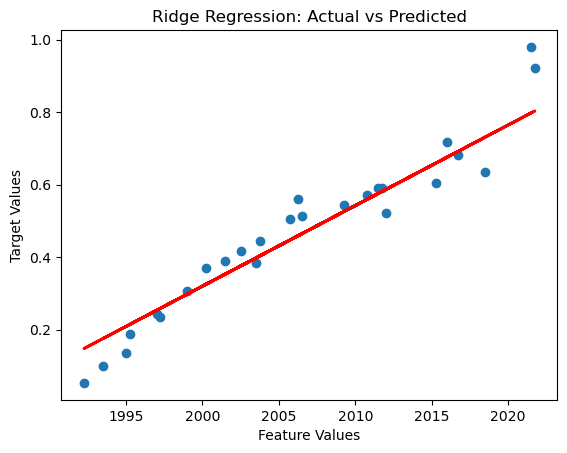

Sporting goods stores
Mean Squared Error: 0.0050420890956071485


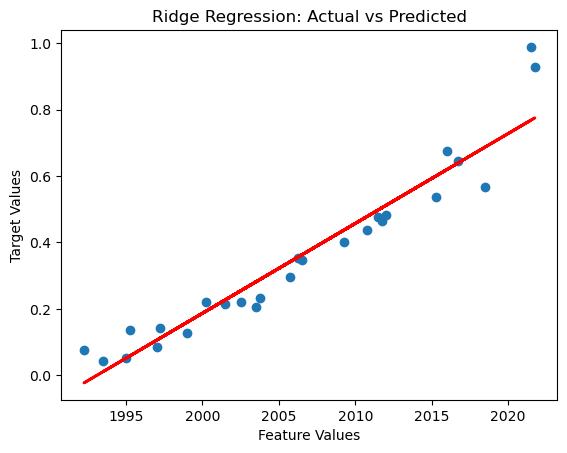

Hobby, toy, and game stores
Mean Squared Error: 0.016174164702055453


In [ ]:
# Keep track of error: 
errors = []
# Census
n = 0
for row in census_y:
    print(census_names[n])
    temp_x = census_x_interval
    temp_y = row
    i = 0
    for num in temp_y:
        if num == 0:
            temp_x = np.delete(temp_x,i)
            temp_y = np.delete(temp_y,i)
        else:
            i+=1

    errors.append(ridge_regression(temp_x,temp_y,alpha=1.0, test_size=0.2, random_state=42))
    n+=1
    

# GDP
print("GDP")
errors.append(ridge_regression(GDP_x_interval,GDP_y,alpha=1.0, test_size=0.2, random_state=42))

# Zillow
print("Zillow")
errors.append(ridge_regression(Zillow_x_interval,Zillow_y,alpha=1.0, test_size=0.2, random_state=42))

# Coffee 
print("Coffee")
errors.append(ridge_regression(Coffee_x_interval,Coffee_y,alpha=1.0, test_size=0.2, random_state=42))

bar_names = census_names.copy()
bar_names.append("GDP")
bar_names.append("Zillow")
bar_names.append("Coffee")
fig = plt.figure(figsize = (20, 5))
plt.bar(bar_names, errors, width = 0.4)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Variables")
plt.ylabel("MSE")
plt.show()



In [ ]:
# Keep track of error: 
errors = []
# Census
n = 0
for row in census_y:
    print(census_names[n])
    temp_x = census_x_interval
    temp_y = row
    i = 0
    for num in temp_y:
        if num == 0:
            temp_x = np.delete(temp_x,i)
            temp_y = np.delete(temp_y,i)
        else:
            i+=1

    errors.append(ridge_regression(temp_x,temp_y,alpha=1.0, test_size=0.2, random_state=42))
    n+=1